# Barca vs Madrid - Analisis de Penaltis LaLiga (2004-2025)

Analisis comparativo de penaltis a favor y en contra para FC Barcelona y Real Madrid.
22 temporadas de datos extraidos de Transfermarkt.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image

# Visual constants (FootballDecoded style)
BACKGROUND_COLOR = '#313332'
FONT_FAMILY = 'DejaVu Sans'

# Team colors
BARCA_COLOR = '#A50044'      # Barcelona Grana      # Azulgrana
BARCA_SECONDARY = '#004D98'  # Azul
MADRID_COLOR = '#FFFFFF'     # Blanco
MADRID_SECONDARY = '#FFD700'  # Gold # Dorado
LALIGA_AVG = '#888888'       # Media liga

# Configure matplotlib
mpl.rcParams['xtick.color'] = 'w'
mpl.rcParams['ytick.color'] = 'w'
mpl.rcParams['text.color'] = 'w'
mpl.rcParams['font.family'] = FONT_FAMILY
mpl.rcParams['axes.labelcolor'] = 'w'
mpl.rcParams['axes.edgecolor'] = 'w'

# Create output directory
os.makedirs('figures', exist_ok=True)

print("Setup complete")

Setup complete


In [2]:
# Helper functions

def add_footer(fig):
    """Add standard FootballDecoded footer to figure."""
    fig.text(0.05, -0.075, "Created by Jaime Oriol", fontweight='bold', 
             fontsize=11, color="white", fontfamily=FONT_FAMILY)
    
    try:
        logo_path = "../../blog/logo/Logo-blanco.png"
        if os.path.exists(logo_path):
            logo = Image.open(logo_path)
            logo_ax = fig.add_axes([0.70, -0.15, 0.35, 0.18])
            logo_ax.imshow(logo)
            logo_ax.axis('off')
        else:
            fig.text(0.85, -0.075, "Football Decoded", fontweight='bold', 
                    fontsize=12, color="white", fontfamily=FONT_FAMILY, ha='right')
    except:
        fig.text(0.85, -0.075, "Football Decoded", fontweight='bold', 
                fontsize=12, color="white", fontfamily=FONT_FAMILY, ha='right')


def style_axis(ax):
    """Apply standard styling to axis."""
    ax.set_facecolor(BACKGROUND_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(1.5)
    ax.grid(alpha=0.2, color='white')
    ax.tick_params(colors='white')


def parse_score(score_str):
    """Parse score string 'X:Y' into tuple (home_goals, away_goals)."""
    if pd.isna(score_str):
        return None, None
    parts = str(score_str).split(':')
    if len(parts) == 2:
        try:
            return int(parts[0]), int(parts[1])
        except:
            return None, None
    return None, None


def get_match_situation(row):
    """Determine match situation using is_home and score."""
    home, away = parse_score(row['score_at_penalty'])
    is_home = row['is_home']
    if home is None or pd.isna(is_home):
        return 'Unknown'
    # Si es local: sus goles son home. Si es visitante: sus goles son away
    my_goals = home if is_home else away
    their_goals = away if is_home else home
    if my_goals > their_goals:
        return 'Winning'
    elif my_goals < their_goals:
        return 'Losing'
    else:
        return 'Drawing'


def get_minute_range(minute):
    """Categorize minute into ranges."""
    if pd.isna(minute):
        return 'Unknown'
    minute = int(minute)
    if minute <= 15:
        return '1-15'
    elif minute <= 30:
        return '16-30'
    elif minute <= 45:
        return '31-45'
    elif minute <= 60:
        return '46-60'
    elif minute <= 75:
        return '61-75'
    else:
        return '76-90+'


print("Helper functions loaded")

Helper functions loaded


In [3]:
# Load data from Excel
EXCEL_PATH = './laliga_penalties_2004_2025.xlsx'

df_favor = pd.read_excel(EXCEL_PATH, sheet_name='Penaltis_A_Favor')
df_contra = pd.read_excel(EXCEL_PATH, sheet_name='Penaltis_En_Contra')
df_goleadores = pd.read_excel(EXCEL_PATH, sheet_name='Goleadores_Por_Temporada')
df_detail = pd.read_excel(EXCEL_PATH, sheet_name='Detalle_Penaltis')
df_top_goleadores = pd.read_excel(EXCEL_PATH, sheet_name='Top_Goleadores_Historico')

# Team names
BARCA = 'FC Barcelona'
MADRID = 'Real Madrid'

# Filter Barca and Madrid data
barca_favor = df_favor[df_favor['team'] == BARCA].copy()
madrid_favor = df_favor[df_favor['team'] == MADRID].copy()
barca_contra = df_contra[df_contra['team'] == BARCA].copy()
madrid_contra = df_contra[df_contra['team'] == MADRID].copy()

# Detail data
barca_detail = df_detail[df_detail['player_team'] == BARCA].copy()
madrid_detail = df_detail[df_detail['player_team'] == MADRID].copy()

# Add derived columns to detail
for df in [barca_detail, madrid_detail, df_detail]:
    df['situation'] = df.apply(get_match_situation, axis=1)
    df['minute_range'] = df['minute'].apply(get_minute_range)

# VAR introduction season
VAR_SEASON = '2018-19'

# Season order for sorting
SEASON_ORDER = sorted(df_favor['season'].unique())

print(f"Data loaded:")
print(f"  - Barca: {len(barca_favor)} seasons, {len(barca_detail)} penalties")
print(f"  - Madrid: {len(madrid_favor)} seasons, {len(madrid_detail)} penalties")
print(f"  - Total detail records: {len(df_detail)}")

Data loaded:
  - Barca: 22 seasons, 173 penalties
  - Madrid: 22 seasons, 194 penalties
  - Total detail records: 2459


---
## 1. Evolucion Temporal
Penaltis a favor y en contra por temporada para ambos equipos.

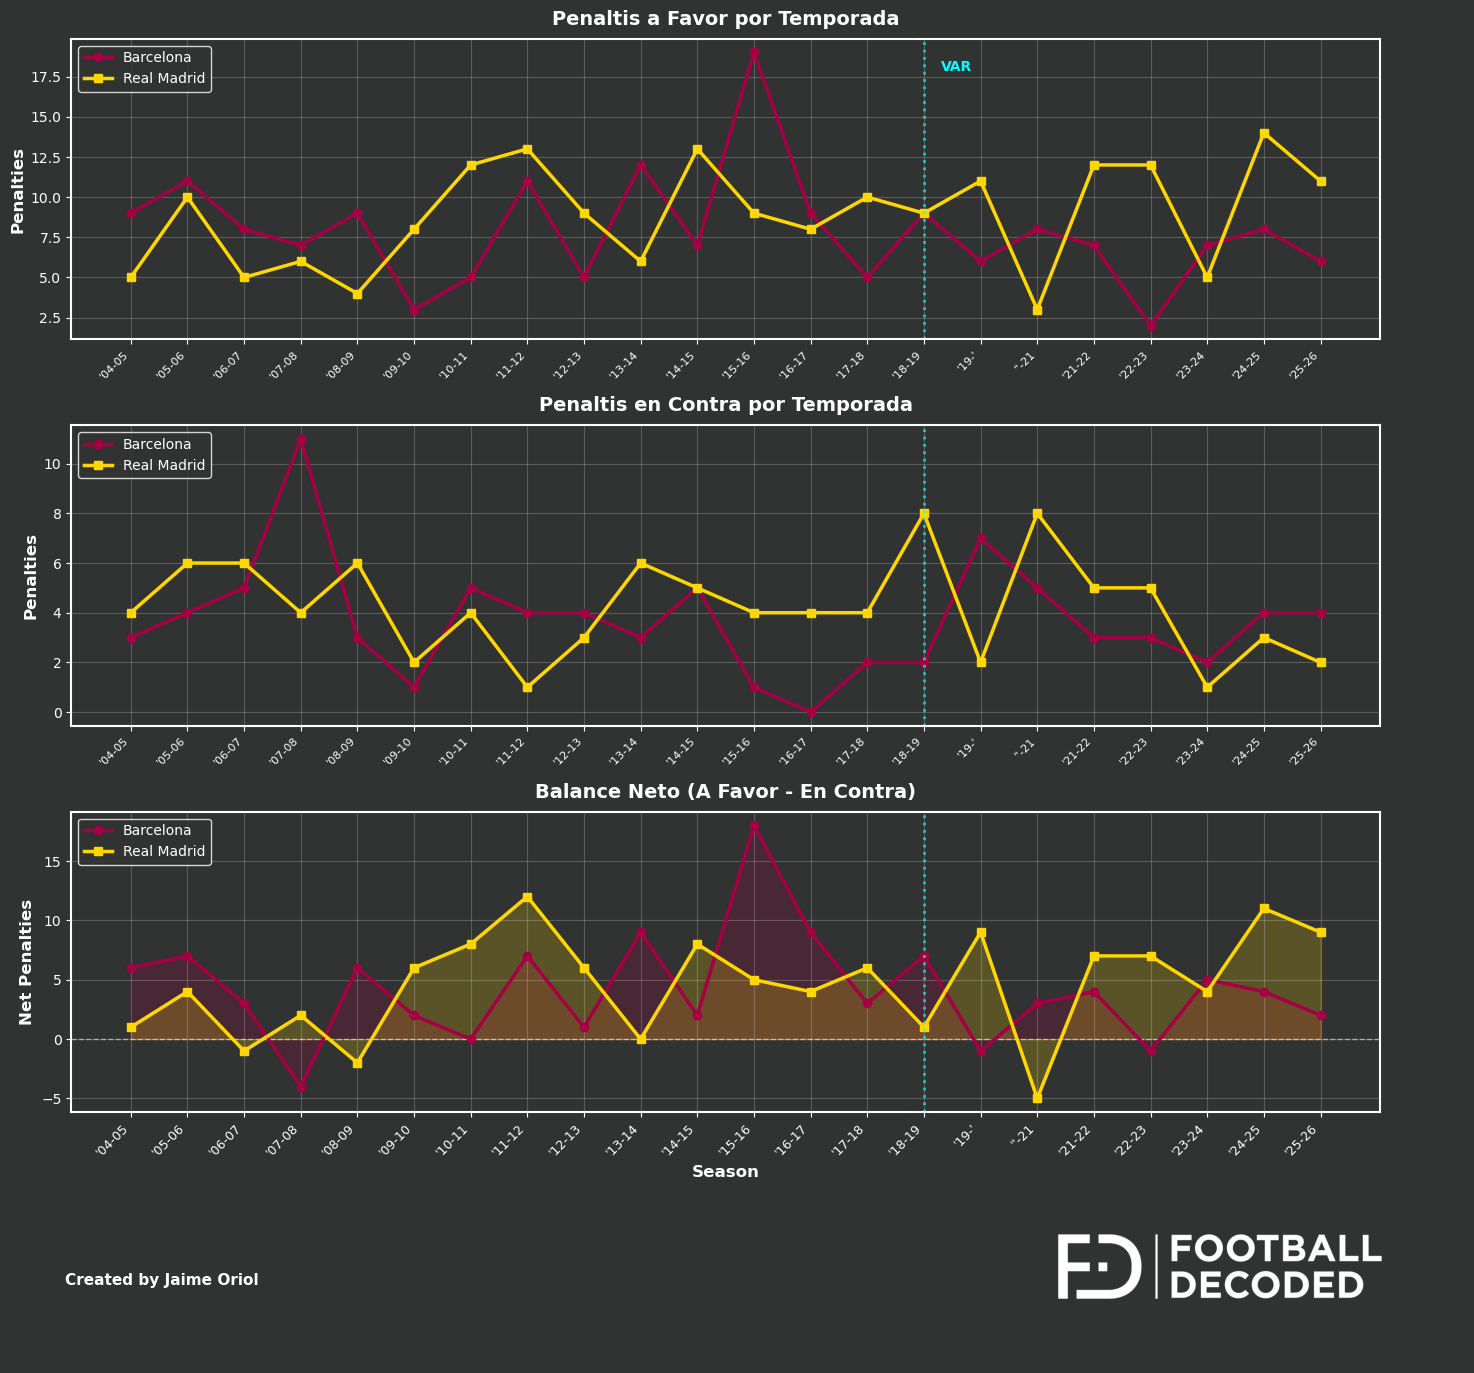


Resumen Evolucion:
Barcelona - Total a favor: 173, En contra: 81
Madrid - Total a favor: 195, En contra: 93


In [4]:
# Prepare data for evolution chart
# Preparar datos de evolucion (Barca 2016-17 tuvo 0 penaltis en contra)
barca_evol = barca_favor[['season', 'penalties_received', 'scored', 'missed']].copy()
barca_evol = barca_evol.merge(
    barca_contra[['season', 'penalties_conceded']], 
    on='season', how='left'
)
barca_evol['penalties_conceded'] = barca_evol['penalties_conceded'].fillna(0).astype(int)
barca_evol['net'] = barca_evol['penalties_received'] - barca_evol['penalties_conceded']

madrid_evol = madrid_favor[['season', 'penalties_received', 'scored', 'missed']].copy()
madrid_evol = madrid_evol.merge(
    madrid_contra[['season', 'penalties_conceded']], 
    on='season', how='left'
)
madrid_evol['penalties_conceded'] = madrid_evol['penalties_conceded'].fillna(0).astype(int)
madrid_evol['net'] = madrid_evol['penalties_received'] - madrid_evol['penalties_conceded']

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(14, 12), facecolor=BACKGROUND_COLOR)

x = range(len(SEASON_ORDER))
x_labels = [s.replace('20', "'").replace('-', '-') for s in SEASON_ORDER]

# Plot 1: Penalties received (a favor)
ax1 = axes[0]
style_axis(ax1)
ax1.plot(x, barca_evol['penalties_received'].values, '-o', color=BARCA_COLOR, 
         linewidth=2.5, markersize=6, label='Barcelona')
ax1.plot(x, madrid_evol['penalties_received'].values, '-s', color=MADRID_SECONDARY, 
         linewidth=2.5, markersize=6, label='Real Madrid')
ax1.set_ylabel('Penalties', fontsize=12, fontweight='bold')
ax1.set_title('Penaltis a Favor por Temporada', fontsize=14, fontweight='bold', pad=10)
ax1.legend(loc='upper left', facecolor=BACKGROUND_COLOR, edgecolor='white')
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)

# Plot 2: Penalties conceded (en contra)
ax2 = axes[1]
style_axis(ax2)
ax2.plot(x, barca_evol['penalties_conceded'].values, '-o', color=BARCA_COLOR, 
         linewidth=2.5, markersize=6, label='Barcelona')
ax2.plot(x, madrid_evol['penalties_conceded'].values, '-s', color=MADRID_SECONDARY, 
         linewidth=2.5, markersize=6, label='Real Madrid')
ax2.set_ylabel('Penalties', fontsize=12, fontweight='bold')
ax2.set_title('Penaltis en Contra por Temporada', fontsize=14, fontweight='bold', pad=10)
ax2.legend(loc='upper left', facecolor=BACKGROUND_COLOR, edgecolor='white')
ax2.set_xticks(x)
ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)

# Plot 3: Net penalties
ax3 = axes[2]
style_axis(ax3)
ax3.axhline(y=0, color='white', linestyle='--', alpha=0.5, linewidth=1)
ax3.plot(x, barca_evol['net'].values, '-o', color=BARCA_COLOR, 
         linewidth=2.5, markersize=6, label='Barcelona')
ax3.plot(x, madrid_evol['net'].values, '-s', color=MADRID_SECONDARY, 
         linewidth=2.5, markersize=6, label='Real Madrid')
ax3.fill_between(x, 0, barca_evol['net'].values, alpha=0.2, color=BARCA_COLOR)
ax3.fill_between(x, 0, madrid_evol['net'].values, alpha=0.2, color=MADRID_SECONDARY)
ax3.set_ylabel('Net Penalties', fontsize=12, fontweight='bold')
ax3.set_xlabel('Season', fontsize=12, fontweight='bold')
ax3.set_title('Balance Neto (A Favor - En Contra)', fontsize=14, fontweight='bold', pad=10)
ax3.legend(loc='upper left', facecolor=BACKGROUND_COLOR, edgecolor='white')
ax3.set_xticks(x)
ax3.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)

# Add VAR line
var_idx = SEASON_ORDER.index(VAR_SEASON)
for ax in axes:
    ax.axvline(x=var_idx, color='cyan', linestyle=':', alpha=0.7, linewidth=2)
axes[0].text(var_idx + 0.3, axes[0].get_ylim()[1] * 0.9, 'VAR', color='cyan', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/01_evolucion_temporal.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

# Summary stats
print("\nResumen Evolucion:")
print(f"Barcelona - Total a favor: {barca_evol['penalties_received'].sum()}, En contra: {barca_evol['penalties_conceded'].sum():.0f}")
print(f"Madrid - Total a favor: {madrid_evol['penalties_received'].sum()}, En contra: {madrid_evol['penalties_conceded'].sum():.0f}")

---
## 2. Comparativa con LaLiga
Desviacion respecto a la media de la liga por temporada.

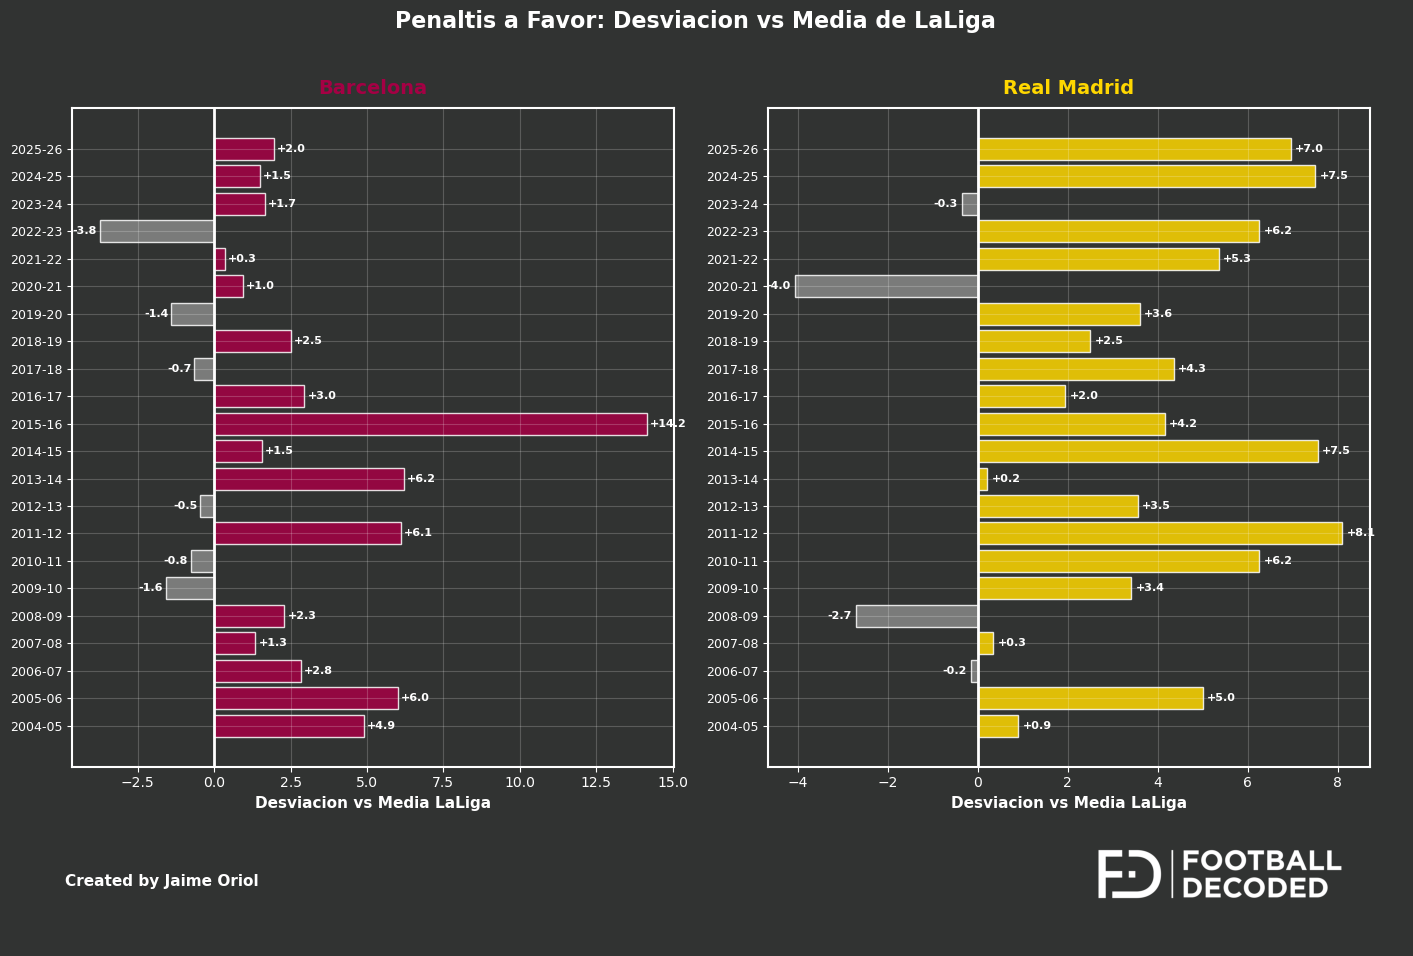


Desviacion media historica vs LaLiga:
Barcelona: +2.21 penaltis/temporada
Madrid: +3.21 penaltis/temporada


In [5]:
# Calculate league average per season
league_avg = df_favor.groupby('season')['penalties_received'].mean().reset_index()
league_avg.columns = ['season', 'league_avg']

# Merge with Barca and Madrid
barca_vs_avg = barca_favor[['season', 'penalties_received']].merge(league_avg, on='season')
barca_vs_avg['deviation'] = barca_vs_avg['penalties_received'] - barca_vs_avg['league_avg']

madrid_vs_avg = madrid_favor[['season', 'penalties_received']].merge(league_avg, on='season')
madrid_vs_avg['deviation'] = madrid_vs_avg['penalties_received'] - madrid_vs_avg['league_avg']

# Create diverging bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 8), facecolor=BACKGROUND_COLOR)

for idx, (ax, data, team, color) in enumerate([
    (axes[0], barca_vs_avg, 'Barcelona', BARCA_COLOR),
    (axes[1], madrid_vs_avg, 'Real Madrid', MADRID_SECONDARY)
]):
    style_axis(ax)
    
    y = range(len(data))
    colors = [color if v >= 0 else LALIGA_AVG for v in data['deviation'].values]
    
    bars = ax.barh(y, data['deviation'].values, color=colors, edgecolor='white', 
                   linewidth=1, alpha=0.85)
    
    ax.axvline(x=0, color='white', linestyle='-', linewidth=2)
    ax.set_yticks(y)
    ax.set_yticklabels(data['season'].values, fontsize=9)
    ax.set_xlabel('Desviacion vs Media LaLiga', fontsize=11, fontweight='bold')
    ax.set_title(f'{team}', fontsize=14, fontweight='bold', pad=10, color=color)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, data['deviation'].values)):
        x_pos = val + 0.1 if val >= 0 else val - 0.1
        ha = 'left' if val >= 0 else 'right'
        ax.text(x_pos, i, f'{val:+.1f}', va='center', ha=ha, 
                fontsize=8, color='white', fontweight='bold')

fig.suptitle('Penaltis a Favor: Desviacion vs Media de LaLiga', 
             fontsize=16, fontweight='bold', color='white', y=1.02)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/02_comparativa_laliga.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

# Summary
print("\nDesviacion media historica vs LaLiga:")
print(f"Barcelona: {barca_vs_avg['deviation'].mean():+.2f} penaltis/temporada")
print(f"Madrid: {madrid_vs_avg['deviation'].mean():+.2f} penaltis/temporada")

---
## 3. Efecto VAR
Comparacion de penaltis antes y despues de la introduccion del VAR (2018-19).

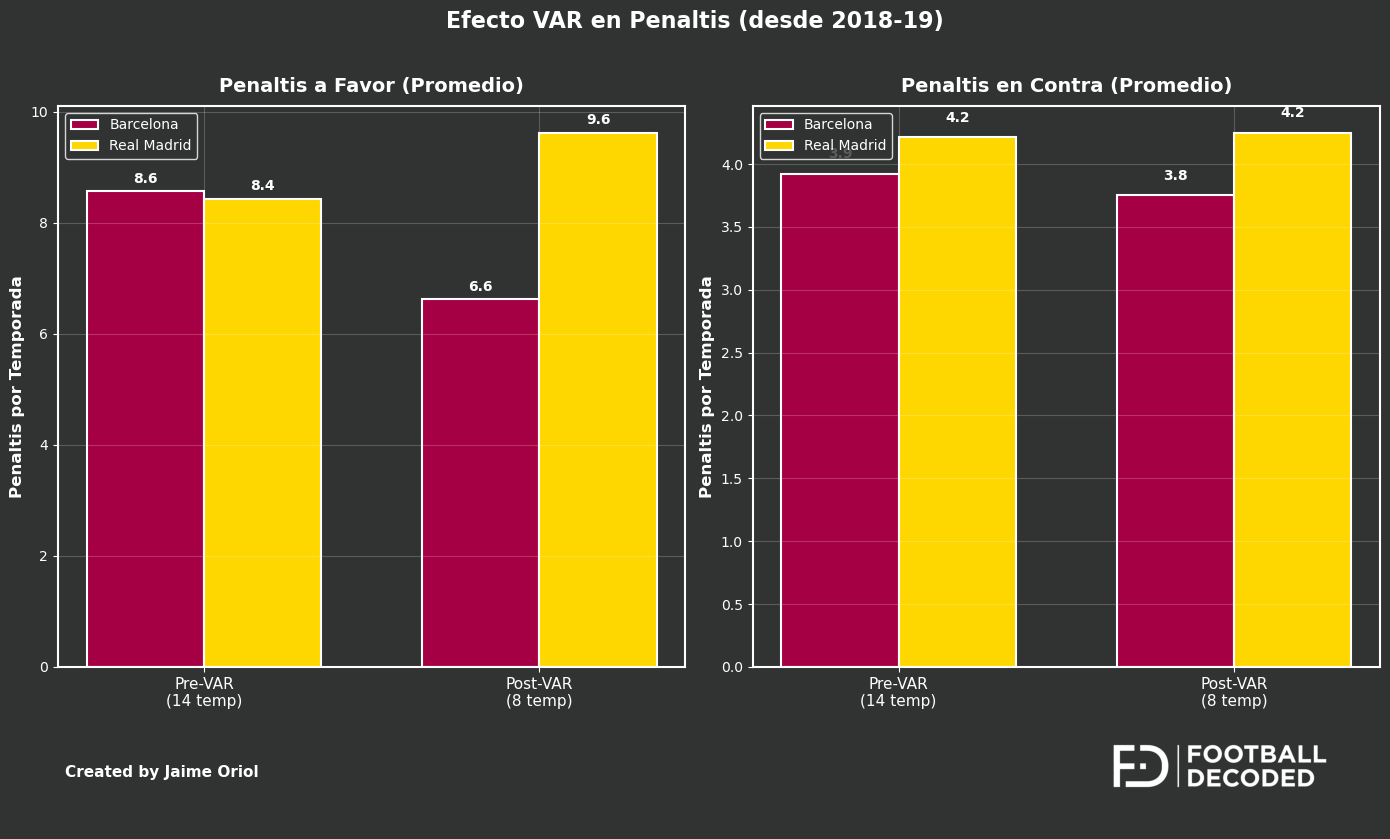


Cambio con VAR:
Barcelona a favor: 8.6 -> 6.6 (-1.9)
Madrid a favor: 8.4 -> 9.6 (+1.2)


In [6]:
# Split data pre/post VAR
pre_var_seasons = [s for s in SEASON_ORDER if s < VAR_SEASON]
post_var_seasons = [s for s in SEASON_ORDER if s >= VAR_SEASON]

def calc_var_stats(favor_df, contra_df, seasons):
    favor = favor_df[favor_df['season'].isin(seasons)]
    contra = contra_df[contra_df['season'].isin(seasons)]
    return {
        'avg_favor': favor['penalties_received'].mean(),
        'avg_contra': contra['penalties_conceded'].mean() if len(contra) > 0 else 0,
        'total_favor': favor['penalties_received'].sum(),
        'total_contra': contra['penalties_conceded'].sum() if len(contra) > 0 else 0,
        'seasons': len(seasons)
    }

barca_pre = calc_var_stats(barca_favor, barca_contra, pre_var_seasons)
barca_post = calc_var_stats(barca_favor, barca_contra, post_var_seasons)
madrid_pre = calc_var_stats(madrid_favor, madrid_contra, pre_var_seasons)
madrid_post = calc_var_stats(madrid_favor, madrid_contra, post_var_seasons)

# Create grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 7), facecolor=BACKGROUND_COLOR)

x = np.arange(2)
width = 0.35

# Plot 1: Penaltis a favor
ax1 = axes[0]
style_axis(ax1)

bars1 = ax1.bar(x - width/2, [barca_pre['avg_favor'], barca_post['avg_favor']], 
                width, label='Barcelona', color=BARCA_COLOR, edgecolor='white', linewidth=1.5)
bars2 = ax1.bar(x + width/2, [madrid_pre['avg_favor'], madrid_post['avg_favor']], 
                width, label='Real Madrid', color=MADRID_SECONDARY, edgecolor='white', linewidth=1.5)

ax1.set_ylabel('Penaltis por Temporada', fontsize=12, fontweight='bold')
ax1.set_title('Penaltis a Favor (Promedio)', fontsize=14, fontweight='bold', pad=10)
ax1.set_xticks(x)
ax1.set_xticklabels([f'Pre-VAR\n({len(pre_var_seasons)} temp)', f'Post-VAR\n({len(post_var_seasons)} temp)'], fontsize=11)
ax1.legend(loc='upper left', facecolor=BACKGROUND_COLOR, edgecolor='white')

for bars in [bars1, bars2]:
    for bar in bars:
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{bar.get_height():.1f}', ha='center', va='bottom', 
                color='white', fontweight='bold', fontsize=10)

# Plot 2: Penaltis en contra
ax2 = axes[1]
style_axis(ax2)

bars3 = ax2.bar(x - width/2, [barca_pre['avg_contra'], barca_post['avg_contra']], 
                width, label='Barcelona', color=BARCA_COLOR, edgecolor='white', linewidth=1.5)
bars4 = ax2.bar(x + width/2, [madrid_pre['avg_contra'], madrid_post['avg_contra']], 
                width, label='Real Madrid', color=MADRID_SECONDARY, edgecolor='white', linewidth=1.5)

ax2.set_ylabel('Penaltis por Temporada', fontsize=12, fontweight='bold')
ax2.set_title('Penaltis en Contra (Promedio)', fontsize=14, fontweight='bold', pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels([f'Pre-VAR\n({len(pre_var_seasons)} temp)', f'Post-VAR\n({len(post_var_seasons)} temp)'], fontsize=11)
ax2.legend(loc='upper left', facecolor=BACKGROUND_COLOR, edgecolor='white')

for bars in [bars3, bars4]:
    for bar in bars:
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{bar.get_height():.1f}', ha='center', va='bottom', 
                color='white', fontweight='bold', fontsize=10)

fig.suptitle('Efecto VAR en Penaltis (desde 2018-19)', 
             fontsize=16, fontweight='bold', color='white', y=1.02)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/03_efecto_var.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

# Summary
print("\nCambio con VAR:")
print(f"Barcelona a favor: {barca_pre['avg_favor']:.1f} -> {barca_post['avg_favor']:.1f} ({barca_post['avg_favor']-barca_pre['avg_favor']:+.1f})")
print(f"Madrid a favor: {madrid_pre['avg_favor']:.1f} -> {madrid_post['avg_favor']:.1f} ({madrid_post['avg_favor']-madrid_pre['avg_favor']:+.1f})")

---
## 4. Factor Local
Comparativa de efectividad como local vs visitante.

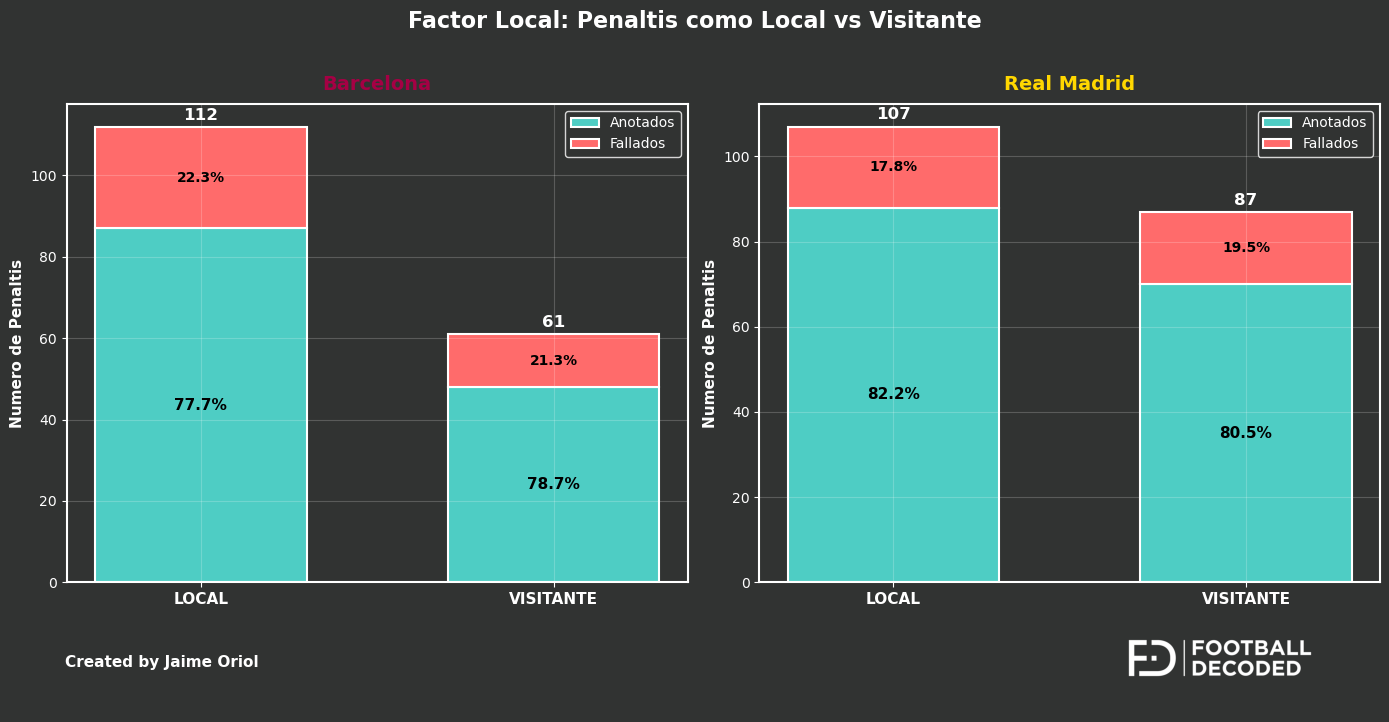


Efectividad como LOCAL vs VISITANTE:
  Barcelona: Local 77.7% (112 pen) | Visitante 78.7% (61 pen)
  Real Madrid: Local 82.2% (107 pen) | Visitante 80.5% (87 pen)


In [7]:
# Factor Local Analysis usando is_home
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=BACKGROUND_COLOR)

for ax, detail, team, color in [
    (axes[0], barca_detail, 'Barcelona', BARCA_COLOR),
    (axes[1], madrid_detail, 'Real Madrid', MADRID_SECONDARY)
]:
    style_axis(ax)
    
    # Calcular stats local vs visitante
    home = detail[detail['is_home'] == True]
    away = detail[detail['is_home'] == False]
    
    home_total = len(home)
    home_scored = home['scored'].sum()
    home_pct = (home_scored / home_total * 100) if home_total > 0 else 0
    
    away_total = len(away)
    away_scored = away['scored'].sum()
    away_pct = (away_scored / away_total * 100) if away_total > 0 else 0
    
    x = np.arange(2)
    totals = [home_total, away_total]
    scored = [home_scored, away_scored]
    missed = [home_total - home_scored, away_total - away_scored]
    pcts = [home_pct, away_pct]
    
    bars1 = ax.bar(x, scored, 0.6, label='Anotados', color='#4ECDC4', edgecolor='white', linewidth=1.5)
    bars2 = ax.bar(x, missed, 0.6, bottom=scored, label='Fallados', color='#FF6B6B', edgecolor='white', linewidth=1.5)
    
    ax.set_ylabel('Numero de Penaltis', fontsize=11, fontweight='bold')
    ax.set_title(f'{team}', fontsize=14, fontweight='bold', pad=10, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(['LOCAL', 'VISITANTE'], fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', facecolor=BACKGROUND_COLOR, edgecolor='white')
    
    # Labels
    for j, (s, m, t, pct) in enumerate(zip(scored, missed, totals, pcts)):
        # Número total arriba
        ax.text(j, t + 1, f'{t}', ha='center', va='bottom', 
               color='white', fontweight='bold', fontsize=12)
        # Porcentaje de acierto (barra turquesa)
        ax.text(j, s/2, f'{pct:.1f}%', ha='center', va='center', 
               color='black', fontweight='bold', fontsize=11)
        # Porcentaje de fallo (barra roja) - solo si hay fallos
        if m > 0:
            miss_pct = 100 - pct
            ax.text(j, s + m/2, f'{miss_pct:.1f}%', ha='center', va='center', 
                   color='black', fontweight='bold', fontsize=10)

fig.suptitle('Factor Local: Penaltis como Local vs Visitante', 
             fontsize=16, fontweight='bold', color='white', y=1.02)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/04_factor_local.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

# Print stats
print("\nEfectividad como LOCAL vs VISITANTE:")
for detail, team in [(barca_detail, 'Barcelona'), (madrid_detail, 'Real Madrid')]:
    home = detail[detail['is_home'] == True]
    away = detail[detail['is_home'] == False]
    home_pct = (home['scored'].sum() / len(home) * 100) if len(home) > 0 else 0
    away_pct = (away['scored'].sum() / len(away) * 100) if len(away) > 0 else 0
    print(f"  {team}: Local {home_pct:.1f}% ({len(home)} pen) | Visitante {away_pct:.1f}% ({len(away)} pen)")

---
## 5. Distribucion por Minutos
En que momentos del partido se producen los penaltis.

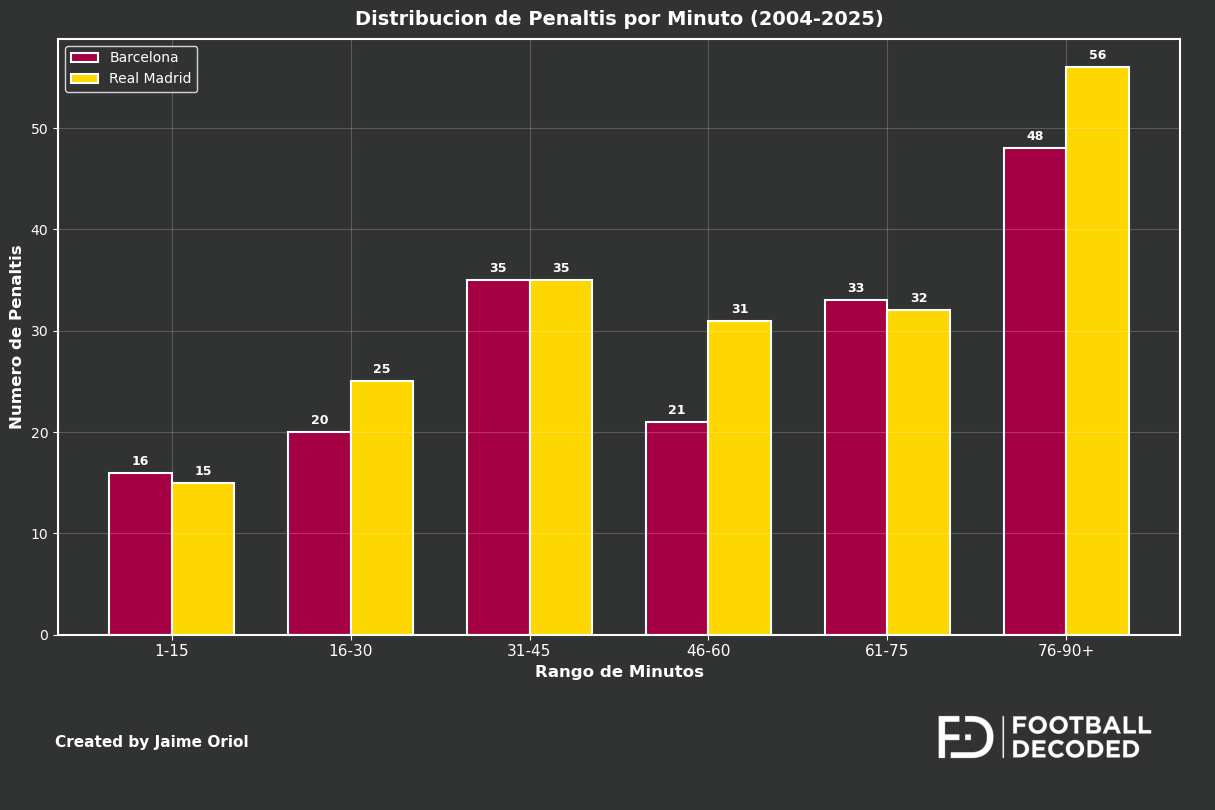


Distribucion por minutos:
Barcelona - Ultimos 15 min (76-90+): 48 (27.7%)
Madrid - Ultimos 15 min (76-90+): 56 (28.9%)


In [8]:
# Prepare minute distribution data
minute_order = ['1-15', '16-30', '31-45', '46-60', '61-75', '76-90+']

barca_minutes = barca_detail.groupby('minute_range').size().reindex(minute_order, fill_value=0)
madrid_minutes = madrid_detail.groupby('minute_range').size().reindex(minute_order, fill_value=0)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 7), facecolor=BACKGROUND_COLOR)
style_axis(ax)

x = np.arange(len(minute_order))
width = 0.35

bars1 = ax.bar(x - width/2, barca_minutes.values, width, label='Barcelona', 
               color=BARCA_COLOR, edgecolor='white', linewidth=1.5)
bars2 = ax.bar(x + width/2, madrid_minutes.values, width, label='Real Madrid', 
               color=MADRID_SECONDARY, edgecolor='white', linewidth=1.5)

ax.set_ylabel('Numero de Penaltis', fontsize=12, fontweight='bold')
ax.set_xlabel('Rango de Minutos', fontsize=12, fontweight='bold')
ax.set_title('Distribucion de Penaltis por Minuto (2004-2025)', 
             fontsize=14, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(minute_order, fontsize=11)
ax.legend(loc='upper left', facecolor=BACKGROUND_COLOR, edgecolor='white')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{int(height)}', ha='center', va='bottom', 
                   color='white', fontweight='bold', fontsize=9)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/05_distribucion_minutos.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

# Summary
print("\nDistribucion por minutos:")
print(f"Barcelona - Ultimos 15 min (76-90+): {barca_minutes['76-90+']} ({barca_minutes['76-90+']/len(barca_detail)*100:.1f}%)")
print(f"Madrid - Ultimos 15 min (76-90+): {madrid_minutes['76-90+']} ({madrid_minutes['76-90+']/len(madrid_detail)*100:.1f}%)")

---
## 6. Analisis por Marcador
Situacion del partido cuando se produce el penalti.

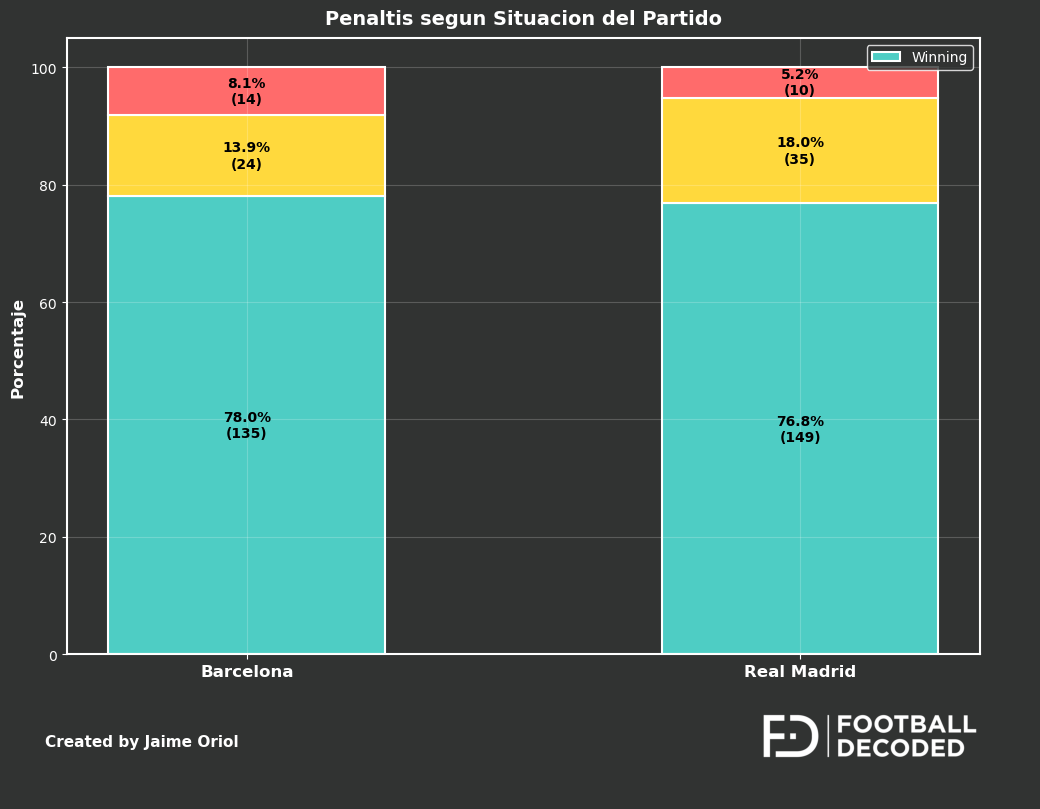


Situacion del partido:
Barcelona - Ganando: 78.0%, Empatando: 13.9%, Perdiendo: 8.1%
Madrid - Ganando: 76.8%, Empatando: 18.0%, Perdiendo: 5.2%


In [9]:
# Prepare situation data
situation_order = ['Winning', 'Drawing', 'Losing']

barca_situation = barca_detail.groupby('situation').size().reindex(situation_order, fill_value=0)
madrid_situation = madrid_detail.groupby('situation').size().reindex(situation_order, fill_value=0)

# Calculate percentages
barca_pct = barca_situation / barca_situation.sum() * 100
madrid_pct = madrid_situation / madrid_situation.sum() * 100

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(10, 7), facecolor=BACKGROUND_COLOR)
style_axis(ax)

x = np.arange(2)
width = 0.5

situation_colors = {'Winning': '#4ECDC4', 'Drawing': '#FFD93D', 'Losing': '#FF6B6B'}

# Stacked bars
bottom_barca = 0
bottom_madrid = 0

for situation in situation_order:
    ax.bar(0, barca_pct[situation], width, bottom=bottom_barca, 
           label=situation if bottom_barca == 0 else '', 
           color=situation_colors[situation], edgecolor='white', linewidth=1.5)
    ax.bar(1, madrid_pct[situation], width, bottom=bottom_madrid, 
           color=situation_colors[situation], edgecolor='white', linewidth=1.5)
    
    # Add percentage labels
    if barca_pct[situation] > 5:
        ax.text(0, bottom_barca + barca_pct[situation]/2, 
               f'{barca_pct[situation]:.1f}%\n({int(barca_situation[situation])})', 
               ha='center', va='center', color='black', fontweight='bold', fontsize=10)
    if madrid_pct[situation] > 5:
        ax.text(1, bottom_madrid + madrid_pct[situation]/2, 
               f'{madrid_pct[situation]:.1f}%\n({int(madrid_situation[situation])})', 
               ha='center', va='center', color='black', fontweight='bold', fontsize=10)
    
    bottom_barca += barca_pct[situation]
    bottom_madrid += madrid_pct[situation]

ax.set_ylabel('Porcentaje', fontsize=12, fontweight='bold')
ax.set_title('Penaltis segun Situacion del Partido', fontsize=14, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(['Barcelona', 'Real Madrid'], fontsize=12, fontweight='bold')
ax.legend(loc='upper right', facecolor=BACKGROUND_COLOR, edgecolor='white')
ax.set_ylim(0, 105)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/06_analisis_marcador.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

print("\nSituacion del partido:")
print(f"Barcelona - Ganando: {barca_pct['Winning']:.1f}%, Empatando: {barca_pct['Drawing']:.1f}%, Perdiendo: {barca_pct['Losing']:.1f}%")
print(f"Madrid - Ganando: {madrid_pct['Winning']:.1f}%, Empatando: {madrid_pct['Drawing']:.1f}%, Perdiendo: {madrid_pct['Losing']:.1f}%")

---
## 7. Criticidad de Penaltis
Penaltis en momentos criticos (empatando/perdiendo en ultimos 15 min) vs no criticos.

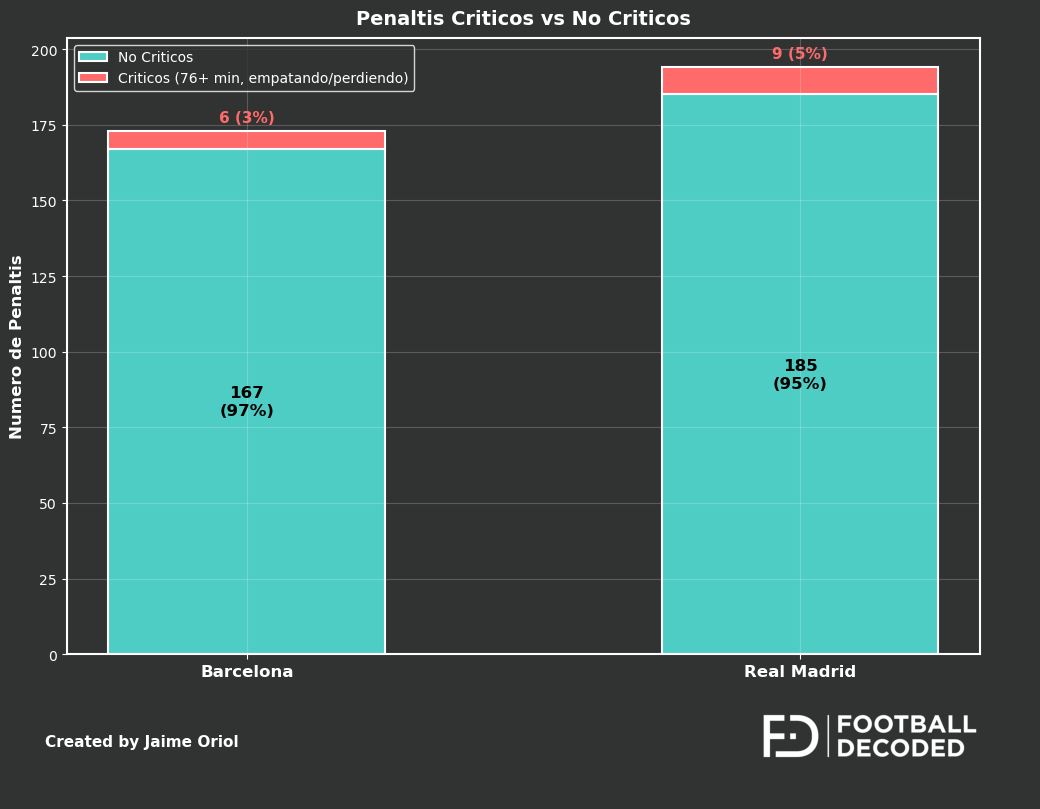


Penaltis criticos:
Barcelona: 6 criticos de 173 (3.5%)
Madrid: 9 criticos de 194 (4.6%)


In [10]:
# Define critical penalty: Drawing/Losing AND minute >= 76
def is_critical(row):
    if pd.isna(row['minute']):
        return False
    return (row['situation'] in ['Drawing', 'Losing']) and (row['minute'] >= 76)

barca_detail['is_critical'] = barca_detail.apply(is_critical, axis=1)
madrid_detail['is_critical'] = madrid_detail.apply(is_critical, axis=1)

# Count critical vs non-critical
barca_critical = barca_detail['is_critical'].sum()
barca_non_critical = len(barca_detail) - barca_critical
madrid_critical = madrid_detail['is_critical'].sum()
madrid_non_critical = len(madrid_detail) - madrid_critical

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(10, 7), facecolor=BACKGROUND_COLOR)
style_axis(ax)

x = np.arange(2)
width = 0.5

# Non-critical (bottom)
bars1 = ax.bar(x, [barca_non_critical, madrid_non_critical], width, 
               label='No Criticos', color='#4ECDC4', edgecolor='white', linewidth=1.5)
# Critical (top)
bars2 = ax.bar(x, [barca_critical, madrid_critical], width, 
               bottom=[barca_non_critical, madrid_non_critical],
               label='Criticos (76+ min, empatando/perdiendo)', 
               color='#FF6B6B', edgecolor='white', linewidth=1.5)

ax.set_ylabel('Numero de Penaltis', fontsize=12, fontweight='bold')
ax.set_title('Penaltis Criticos vs No Criticos', fontsize=14, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(['Barcelona', 'Real Madrid'], fontsize=12, fontweight='bold')
ax.legend(loc='upper left', facecolor=BACKGROUND_COLOR, edgecolor='white')

# Add labels
for i, (nc, c) in enumerate([(barca_non_critical, barca_critical), (madrid_non_critical, madrid_critical)]):
    total = nc + c
    # No críticos: texto negro dentro de la barra turquesa
    ax.text(i, nc/2, f'{nc}\n({nc/total*100:.0f}%)', ha='center', va='center', 
           color='black', fontweight='bold', fontsize=12)
    # Críticos: texto ENCIMA de la barra (porque es muy pequeña)
    ax.text(i, total + 2, f'{c} ({c/total*100:.0f}%)', ha='center', va='bottom', 
           color='#FF6B6B', fontweight='bold', fontsize=11)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/07_criticidad.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

print("\nPenaltis criticos:")
print(f"Barcelona: {barca_critical} criticos de {len(barca_detail)} ({barca_critical/len(barca_detail)*100:.1f}%)")
print(f"Madrid: {madrid_critical} criticos de {len(madrid_detail)} ({madrid_critical/len(madrid_detail)*100:.1f}%)")

---
## 8. Top Goleadores
Maximos goleadores de penalti de cada equipo.

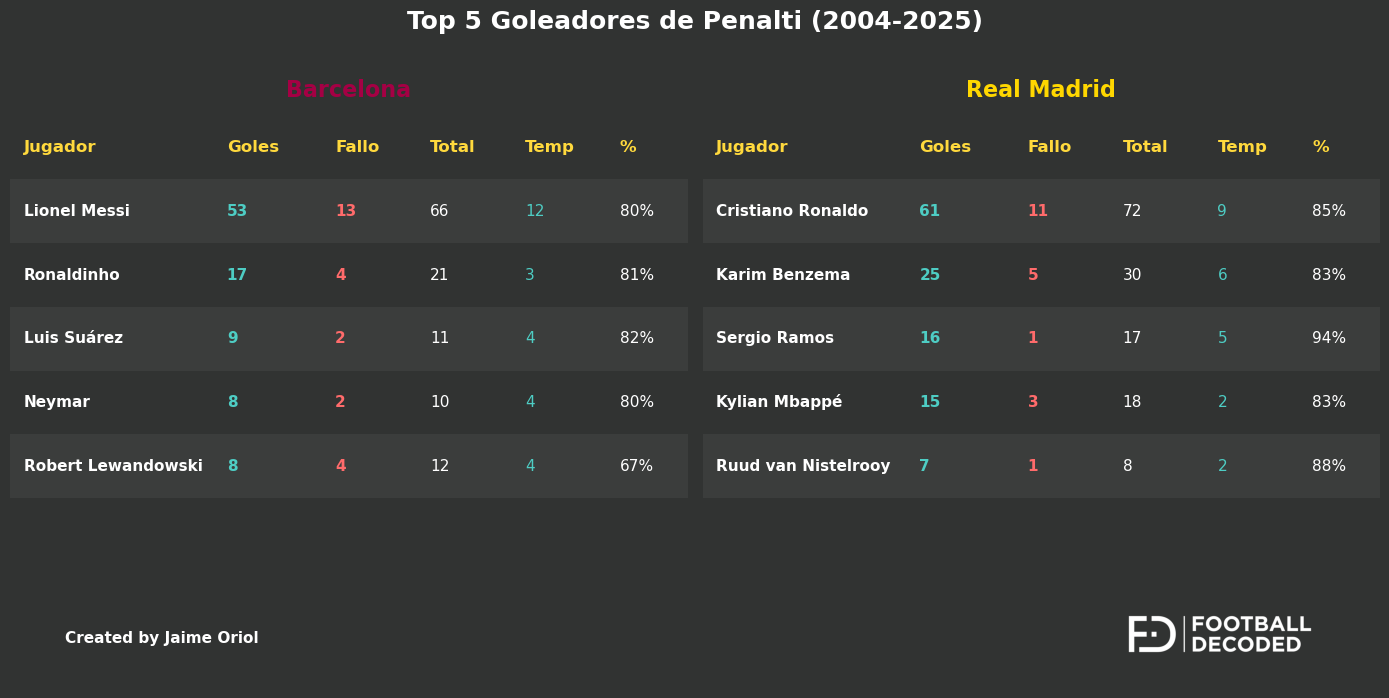


Top goleador de cada equipo:
Barcelona: Lionel Messi (53 goles en 12 temporadas)
Madrid: Cristiano Ronaldo (61 goles en 9 temporadas)


In [21]:
# Get top scorers for each team (Top 5 con temporadas)
barca_scorers = df_goleadores[df_goleadores['team'] == BARCA].groupby('player').agg({
    'penalties': 'sum',
    'scored': 'sum',
    'missed': 'sum',
    'season': 'count'
}).reset_index()
barca_scorers.columns = ['player', 'penalties', 'scored', 'missed', 'seasons']
barca_scorers['conversion'] = (barca_scorers['scored'] / barca_scorers['penalties'] * 100).round(1)
barca_scorers = barca_scorers.sort_values('scored', ascending=False).head(5)

madrid_scorers = df_goleadores[df_goleadores['team'] == MADRID].groupby('player').agg({
    'penalties': 'sum',
    'scored': 'sum',
    'missed': 'sum',
    'season': 'count'
}).reset_index()
madrid_scorers.columns = ['player', 'penalties', 'scored', 'missed', 'seasons']
madrid_scorers['conversion'] = (madrid_scorers['scored'] / madrid_scorers['penalties'] * 100).round(1)
madrid_scorers = madrid_scorers.sort_values('scored', ascending=False).head(5)

# Create visual table - Top 5 con temporadas
def create_scorers_table(df, team_name, team_color, ax):
    ax.set_facecolor(BACKGROUND_COLOR)
    ax.axis('off')
    
    # Table parameters - más grande
    row_height = 0.12
    col_positions = [0.02, 0.32, 0.48, 0.62, 0.76, 0.90]
    headers = ['Jugador', 'Goles', 'Fallo', 'Total', 'Temp', '%']
    
    # Title
    ax.text(0.5, 0.95, team_name, ha='center', va='top', fontsize=16, 
           fontweight='bold', color=team_color)
    
    # Header
    y = 0.82
    for header, x in zip(headers, col_positions):
        ax.text(x, y, header, ha='left', va='center', fontsize=12, 
               fontweight='bold', color='#FFD93D')
    
    # Rows - solo 5
    for idx, (_, row) in enumerate(df.iterrows()):
        y = 0.70 - idx * row_height
        
        # Alternating background
        if idx % 2 == 0:
            rect = Rectangle((0, y - row_height/2), 1, row_height, 
                           facecolor='white', alpha=0.05, transform=ax.transAxes)
            ax.add_patch(rect)
        
        # Name
        name = row['player'][:20] if len(row['player']) > 20 else row['player']
        ax.text(col_positions[0], y, name, ha='left', va='center', 
               fontsize=11, color='white', fontweight='bold')
        ax.text(col_positions[1], y, f"{int(row['scored'])}", ha='left', va='center', 
               fontsize=11, color='#4ECDC4', fontweight='bold')
        ax.text(col_positions[2], y, f"{int(row['missed'])}", ha='left', va='center', 
               fontsize=11, color='#FF6B6B', fontweight='bold')
        ax.text(col_positions[3], y, f"{int(row['penalties'])}", ha='left', va='center', 
               fontsize=11, color='white')
        ax.text(col_positions[4], y, f"{int(row['seasons'])}", ha='left', va='center', 
               fontsize=11, color='#4ECDC4')
        ax.text(col_positions[5], y, f"{row['conversion']:.0f}%", ha='left', va='center', 
               fontsize=11, color='white')

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=BACKGROUND_COLOR)

create_scorers_table(barca_scorers, 'Barcelona', BARCA_COLOR, axes[0])
create_scorers_table(madrid_scorers, 'Real Madrid', MADRID_SECONDARY, axes[1])

fig.suptitle('Top 5 Goleadores de Penalti (2004-2025)', 
             fontsize=18, fontweight='bold', color='white', y=0.98)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/08_top_goleadores.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

print("\nTop goleador de cada equipo:")
print(f"Barcelona: {barca_scorers.iloc[0]['player']} ({int(barca_scorers.iloc[0]['scored'])} goles en {int(barca_scorers.iloc[0]['seasons'])} temporadas)")
print(f"Madrid: {madrid_scorers.iloc[0]['player']} ({int(madrid_scorers.iloc[0]['scored'])} goles en {int(madrid_scorers.iloc[0]['seasons'])} temporadas)")

---
## 9. Efectividad bajo Presion
Tasa de conversion general vs en momentos criticos.

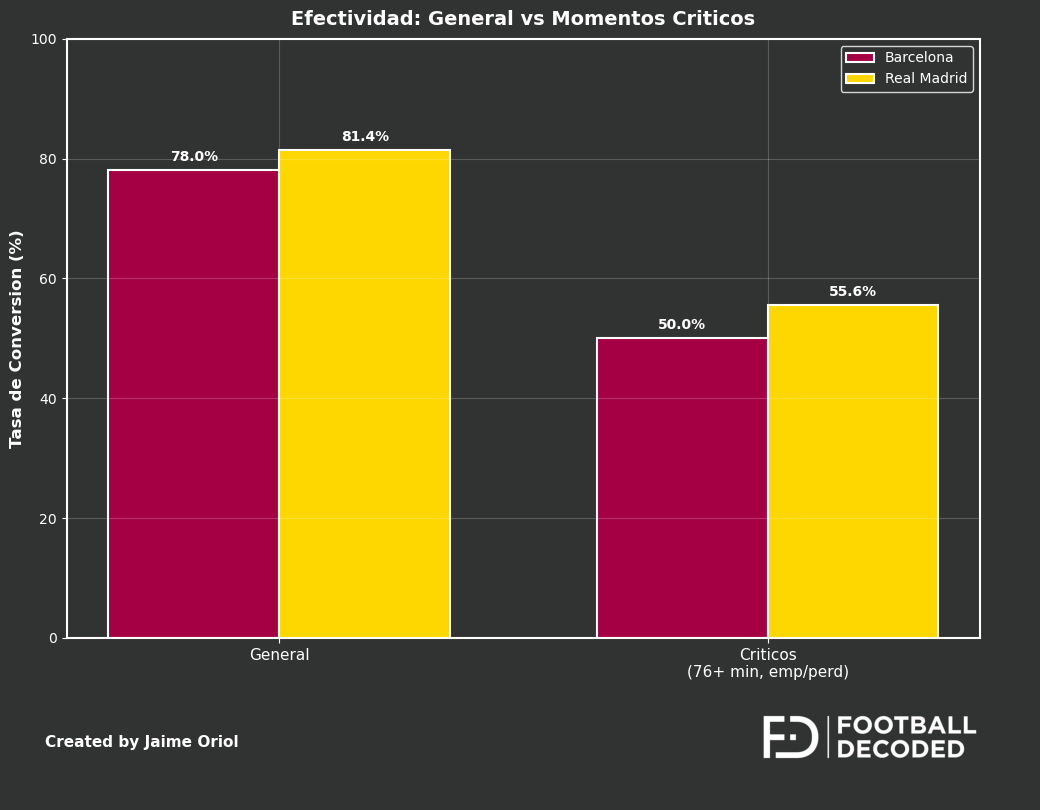


Efectividad:
Barcelona - General: 78.0%, Criticos: 50.0%
Madrid - General: 81.4%, Criticos: 55.6%


In [12]:
# Calculate conversion rates
barca_conv_general = barca_detail['scored'].mean() * 100
barca_conv_critical = barca_detail[barca_detail['is_critical']]['scored'].mean() * 100 if barca_detail['is_critical'].any() else 0

madrid_conv_general = madrid_detail['scored'].mean() * 100
madrid_conv_critical = madrid_detail[madrid_detail['is_critical']]['scored'].mean() * 100 if madrid_detail['is_critical'].any() else 0

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 7), facecolor=BACKGROUND_COLOR)
style_axis(ax)

x = np.arange(2)
width = 0.35

bars1 = ax.bar(x - width/2, [barca_conv_general, barca_conv_critical], width, 
               label='Barcelona', color=BARCA_COLOR, edgecolor='white', linewidth=1.5)
bars2 = ax.bar(x + width/2, [madrid_conv_general, madrid_conv_critical], width, 
               label='Real Madrid', color=MADRID_SECONDARY, edgecolor='white', linewidth=1.5)

ax.set_ylabel('Tasa de Conversion (%)', fontsize=12, fontweight='bold')
ax.set_title('Efectividad: General vs Momentos Criticos', fontsize=14, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(['General', 'Criticos\n(76+ min, emp/perd)'], fontsize=11)
ax.legend(loc='upper right', facecolor=BACKGROUND_COLOR, edgecolor='white')
ax.set_ylim(0, 100)

for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
               f'{bar.get_height():.1f}%', ha='center', va='bottom', 
               color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/09_efectividad_presion.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

print("\nEfectividad:")
print(f"Barcelona - General: {barca_conv_general:.1f}%, Criticos: {barca_conv_critical:.1f}%")
print(f"Madrid - General: {madrid_conv_general:.1f}%, Criticos: {madrid_conv_critical:.1f}%")

---
## 10. El Clasico
Penaltis en enfrentamientos directos entre Barcelona y Real Madrid.

=== PENALTIS EN EL CLASICO ===

Madrid tirando vs Barcelona: 10
  2006-07 - Ruud van Nistelrooy vs FC Barcelona (min 13, 1:2) -> GOL
  2007-08 - Ruud van Nistelrooy vs FC Barcelona (min 79, 4:0) -> GOL
  2010-11 - Cristiano Ronaldo vs FC Barcelona (min 82, 1:1) -> GOL
  2013-14 - Cristiano Ronaldo vs FC Barcelona (min 55, 3:2) -> GOL
  2014-15 - Cristiano Ronaldo vs FC Barcelona (min 35, 1:1) -> GOL
  2020-21 - Sergio Ramos vs FC Barcelona (min 63, 1:2) -> GOL
  2022-23 - Rodrygo vs FC Barcelona (min 90, 3:1) -> GOL
  2023-24 - Vinicius Junior vs FC Barcelona (min 18, 1:1) -> GOL
  2024-25 - Kylian Mbappé vs FC Barcelona (min 5, 0:1) -> GOL
  2025-26 - Kylian Mbappé vs FC Barcelona (min 52, 2:1) -> FALLO

Barcelona tirando vs Madrid: 8
  2004-05 - Ronaldinho vs Real Madrid (min 77, 3:0) -> GOL
  2005-06 - Ronaldinho vs Real Madrid (min 22, 1:0) -> GOL
  2008-09 - Samuel Eto'o vs Real Madrid (min 70, 0:0) -> FALLO
  2010-11 - Lionel Messi vs Real Madrid (min 53, 0:1) -> GOL
  2013-14 - 

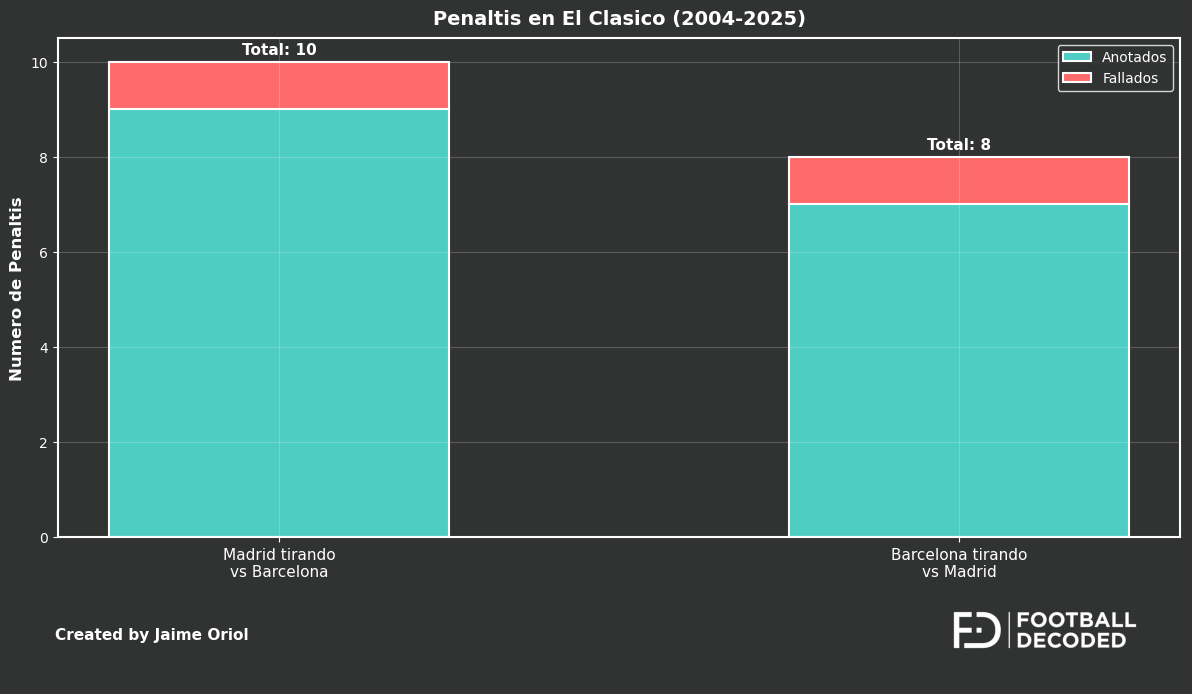

In [13]:
# El Clasico penalties (rival is home_team or away_team)
clasico_madrid = df_detail[(df_detail['player_team'] == MADRID) & 
                           ((df_detail['home_team'] == BARCA) | (df_detail['away_team'] == BARCA))].copy()
clasico_barca = df_detail[(df_detail['player_team'] == BARCA) & 
                          ((df_detail['home_team'] == MADRID) | (df_detail['away_team'] == MADRID))].copy()

# Combine for timeline
clasico_all = pd.concat([clasico_madrid, clasico_barca])
clasico_all = clasico_all.sort_values('season')

print("=== PENALTIS EN EL CLASICO ===")
print(f"\nMadrid tirando vs Barcelona: {len(clasico_madrid)}")
if len(clasico_madrid) > 0:
    for _, row in clasico_madrid.iterrows():
        result = 'GOL' if row['scored'] else 'FALLO'
        print(f"  {row['season']} - {row['player']} vs {row['away_team'] if row['is_home'] else row['home_team']} (min {int(row['minute'])}, {row['score_at_penalty']}) -> {result}")

print(f"\nBarcelona tirando vs Madrid: {len(clasico_barca)}")
if len(clasico_barca) > 0:
    for _, row in clasico_barca.iterrows():
        result = 'GOL' if row['scored'] else 'FALLO'
        print(f"  {row['season']} - {row['player']} vs {row['away_team'] if row['is_home'] else row['home_team']} (min {int(row['minute'])}, {row['score_at_penalty']}) -> {result}")

# Create visual summary
if len(clasico_all) > 0:
    fig, ax = plt.subplots(figsize=(12, 6), facecolor=BACKGROUND_COLOR)
    style_axis(ax)
    
    # Summary bars
    x = [0, 1]
    heights = [len(clasico_madrid), len(clasico_barca)]
    scored = [clasico_madrid['scored'].sum(), clasico_barca['scored'].sum()]
    missed = [len(clasico_madrid) - clasico_madrid['scored'].sum(), 
              len(clasico_barca) - clasico_barca['scored'].sum()]
    
    bars1 = ax.bar(x, scored, 0.5, label='Anotados', color='#4ECDC4', edgecolor='white', linewidth=1.5)
    bars2 = ax.bar(x, missed, 0.5, bottom=scored, label='Fallados', color='#FF6B6B', edgecolor='white', linewidth=1.5)
    
    ax.set_ylabel('Numero de Penaltis', fontsize=12, fontweight='bold')
    ax.set_title('Penaltis en El Clasico (2004-2025)', fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(['Madrid tirando\nvs Barcelona', 'Barcelona tirando\nvs Madrid'], fontsize=11)
    ax.legend(loc='upper right', facecolor=BACKGROUND_COLOR, edgecolor='white')
    
    for i, (s, m) in enumerate(zip(scored, missed)):
        total = s + m
        if total > 0:
            ax.text(i, total + 0.1, f'Total: {int(total)}', ha='center', va='bottom', 
                   color='white', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    add_footer(fig)
    fig.savefig('figures/12_el_clasico.png', 
                dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    plt.show()
else:
    print("\nNo hay datos de El Clasico.")

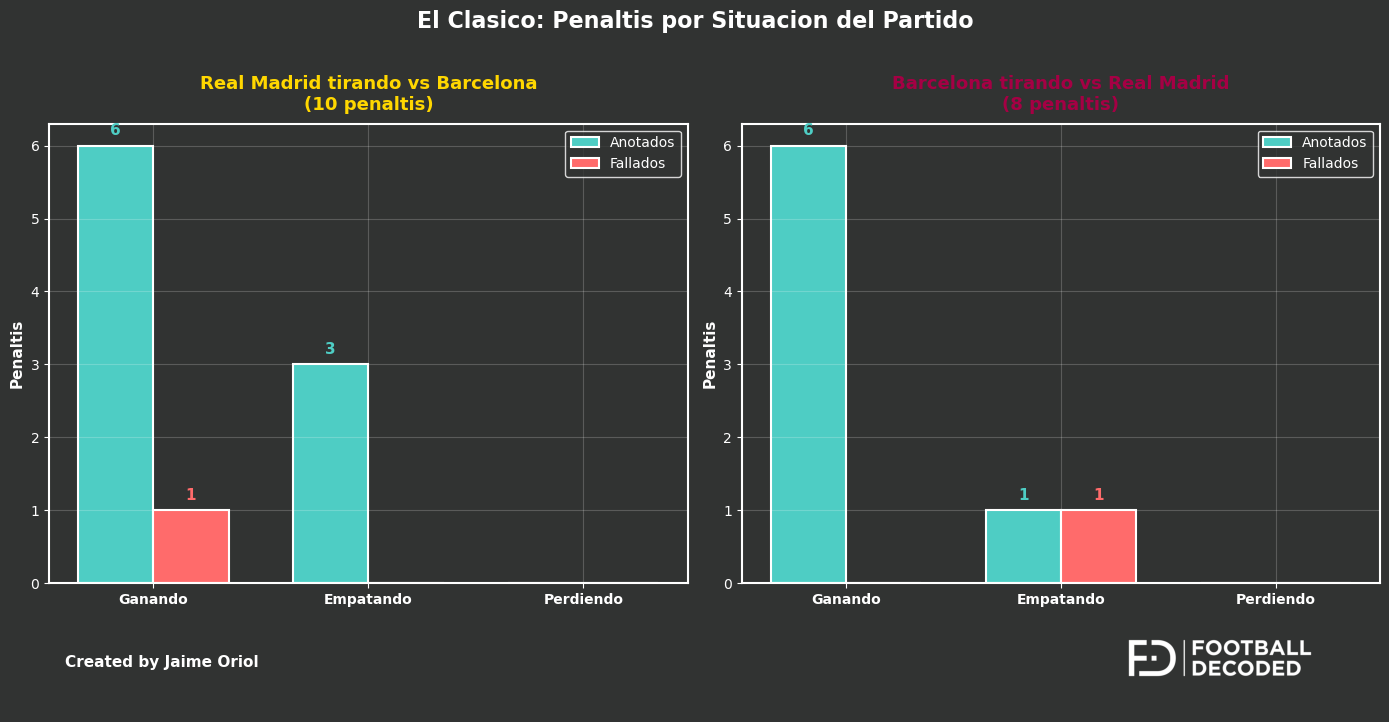


=== RESUMEN EL CLASICO POR SITUACION ===

Madrid tirando: 9/10 anotados (90%)

Barcelona tirando: 7/8 anotados (88%)


In [14]:
# Gráfico detallado El Clásico: Situación + Anotados/Fallados
if len(clasico_all) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=BACKGROUND_COLOR)
    
    for idx, (ax, data, team_lanzador, rival, color) in enumerate([
        (axes[0], clasico_madrid, 'Real Madrid', 'Barcelona', MADRID_SECONDARY),
        (axes[1], clasico_barca, 'Barcelona', 'Real Madrid', BARCA_COLOR)
    ]):
        style_axis(ax)
        
        if len(data) == 0:
            ax.text(0.5, 0.5, 'Sin datos', ha='center', va='center', color='white', fontsize=14)
            ax.set_title(f'{team_lanzador} vs {rival}', fontsize=14, fontweight='bold', color=color)
            continue
        
        # Calcular situación usando is_home
        situations = []
        for _, row in data.iterrows():
            home, away = parse_score(row['score_at_penalty'])
            if home is not None:
                my_goals = home if row['is_home'] else away
                their_goals = away if row['is_home'] else home
                if my_goals > their_goals:
                    situations.append('Ganando')
                elif my_goals < their_goals:
                    situations.append('Perdiendo')
                else:
                    situations.append('Empatando')
            else:
                situations.append('?')
        
        data = data.copy()
        data['situacion'] = situations
        
        # Agrupar por situación
        sit_order = ['Ganando', 'Empatando', 'Perdiendo']
        sit_colors = {'Ganando': '#4ECDC4', 'Empatando': '#FFD93D', 'Perdiendo': '#FF6B6B'}
        
        x = np.arange(len(sit_order))
        width = 0.35
        
        goles = []
        fallos = []
        for sit in sit_order:
            sit_data = data[data['situacion'] == sit]
            goles.append(sit_data['scored'].sum())
            fallos.append(len(sit_data) - sit_data['scored'].sum())
        
        bars1 = ax.bar(x - width/2, goles, width, label='Anotados', color='#4ECDC4', edgecolor='white', linewidth=1.5)
        bars2 = ax.bar(x + width/2, fallos, width, label='Fallados', color='#FF6B6B', edgecolor='white', linewidth=1.5)
        
        ax.set_ylabel('Penaltis', fontsize=11, fontweight='bold')
        ax.set_title(f'{team_lanzador} tirando vs {rival}\n({len(data)} penaltis)', 
                    fontsize=13, fontweight='bold', color=color, pad=10)
        ax.set_xticks(x)
        ax.set_xticklabels(sit_order, fontsize=10, fontweight='bold')
        ax.legend(loc='upper right', facecolor=BACKGROUND_COLOR, edgecolor='white')
        
        # Labels
        for j, (g, f) in enumerate(zip(goles, fallos)):
            if g > 0:
                ax.text(j - width/2, g + 0.1, f'{int(g)}', ha='center', va='bottom', 
                       color='#4ECDC4', fontweight='bold', fontsize=11)
            if f > 0:
                ax.text(j + width/2, f + 0.1, f'{int(f)}', ha='center', va='bottom', 
                       color='#FF6B6B', fontweight='bold', fontsize=11)
    
    fig.suptitle('El Clasico: Penaltis por Situacion del Partido', 
                 fontsize=16, fontweight='bold', color='white', y=1.02)
    
    plt.tight_layout()
    add_footer(fig)
    fig.savefig('figures/10b_clasico_situacion.png', 
                dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    plt.show()
    
    # Resumen
    print("\n=== RESUMEN EL CLASICO POR SITUACION ===")
    for data, team in [(clasico_madrid, 'Madrid'), (clasico_barca, 'Barcelona')]:
        if len(data) > 0:
            total = len(data)
            goles = data['scored'].sum()
            print(f"\n{team} tirando: {goles}/{total} anotados ({goles/total*100:.0f}%)")


---
## 11. Resumen Ejecutivo
Indice de favorecimiento global y conclusiones.

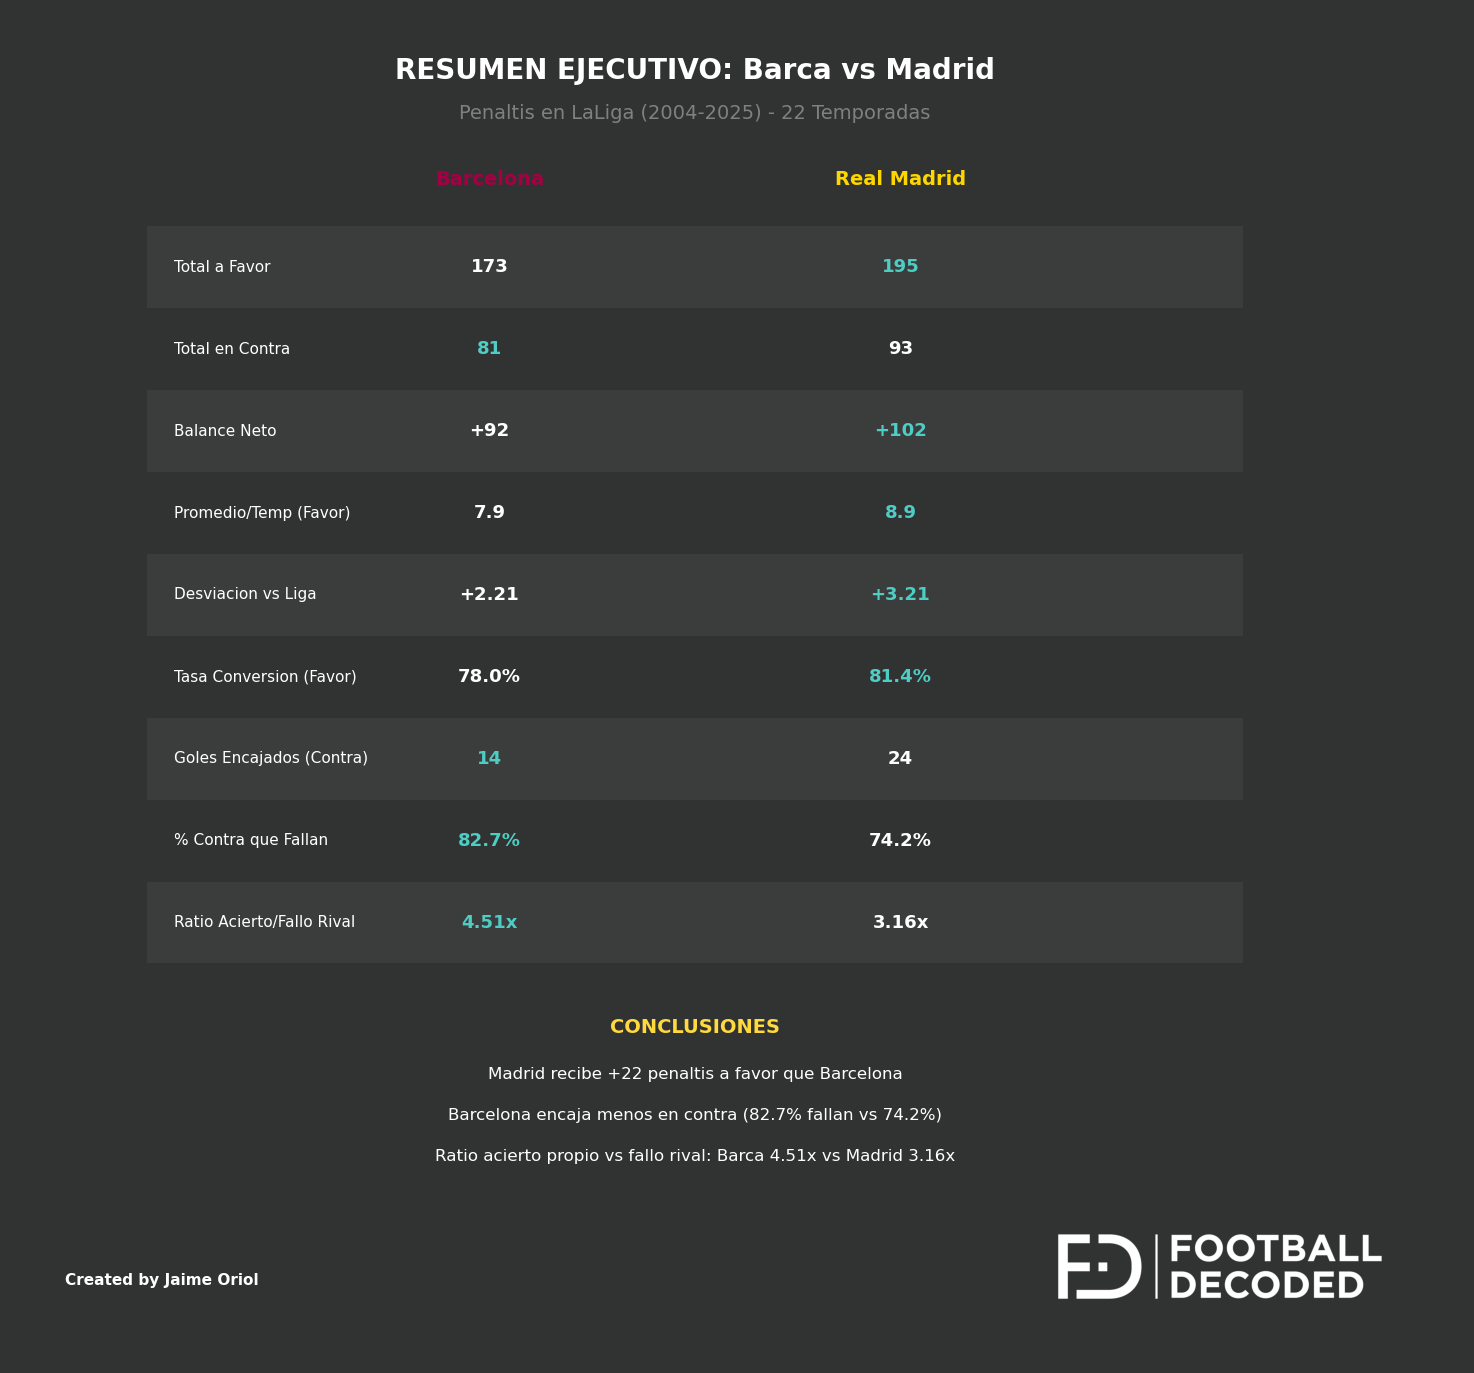


RESUMEN FINAL

Barcelona:
  Total a Favor: 173
  Total en Contra: 81
  Balance Neto: +92
  Promedio/Temp (Favor): 7.9
  Desviacion vs Liga: +2.21
  Tasa Conversion (Favor): 78.0%
  Goles Encajados (Contra): 14
  % Contra que Fallan: 82.7%
  Ratio Acierto/Fallo Rival: 4.51x

Real Madrid:
  Total a Favor: 195
  Total en Contra: 93
  Balance Neto: +102
  Promedio/Temp (Favor): 8.9
  Desviacion vs Liga: +3.21
  Tasa Conversion (Favor): 81.4%
  Goles Encajados (Contra): 24
  % Contra que Fallan: 74.2%
  Ratio Acierto/Fallo Rival: 3.16x



In [15]:
# Calculate summary metrics
barca_contra_goles = barca_contra['goals_against'].sum()
madrid_contra_goles = madrid_contra['goals_against'].sum()
barca_contra_total = barca_contra['penalties_conceded'].sum()
madrid_contra_total = madrid_contra['penalties_conceded'].sum()

# Porcentaje de en contra que fallan (no gol)
barca_contra_fallan_pct = (1 - barca_contra_goles/barca_contra_total) * 100
madrid_contra_fallan_pct = (1 - madrid_contra_goles/madrid_contra_total) * 100

# Ratio acierto propio vs fallo rival
barca_ratio_vs_contra = (barca_detail['scored'].mean() * 100) / (barca_contra_goles/barca_contra_total * 100)
madrid_ratio_vs_contra = (madrid_detail['scored'].mean() * 100) / (madrid_contra_goles/madrid_contra_total * 100)

summary = {
    'Barcelona': {
        'total_favor': barca_favor['penalties_received'].sum(),
        'total_contra': barca_contra_total,
        'net': barca_favor['penalties_received'].sum() - barca_contra_total,
        'avg_favor': barca_favor['penalties_received'].mean(),
        'avg_contra': barca_contra['penalties_conceded'].mean(),
        'deviation_vs_league': barca_vs_avg['deviation'].mean(),
        'conversion_rate': barca_detail['scored'].mean() * 100,
        'contra_goles': barca_contra_goles,
        'contra_fallan_pct': barca_contra_fallan_pct,
        'ratio_vs_contra': barca_ratio_vs_contra
    },
    'Real Madrid': {
        'total_favor': madrid_favor['penalties_received'].sum(),
        'total_contra': madrid_contra_total,
        'net': madrid_favor['penalties_received'].sum() - madrid_contra_total,
        'avg_favor': madrid_favor['penalties_received'].mean(),
        'avg_contra': madrid_contra['penalties_conceded'].mean(),
        'deviation_vs_league': madrid_vs_avg['deviation'].mean(),
        'conversion_rate': madrid_detail['scored'].mean() * 100,
        'contra_goles': madrid_contra_goles,
        'contra_fallan_pct': madrid_contra_fallan_pct,
        'ratio_vs_contra': madrid_ratio_vs_contra
    }
}

# Create scorecard visualization
fig, ax = plt.subplots(figsize=(14, 12), facecolor=BACKGROUND_COLOR)
ax.set_facecolor(BACKGROUND_COLOR)
ax.axis('off')

# Title
ax.text(0.5, 0.96, 'RESUMEN EJECUTIVO: Barca vs Madrid', 
        ha='center', va='top', fontsize=20, fontweight='bold', color='white')
ax.text(0.5, 0.92, 'Penaltis en LaLiga (2004-2025) - 22 Temporadas', 
        ha='center', va='top', fontsize=14, color='gray')

# Metrics grid
metrics = [
    ('Total a Favor', 'total_favor', '{:.0f}'),
    ('Total en Contra', 'total_contra', '{:.0f}'),
    ('Balance Neto', 'net', '{:+.0f}'),
    ('Promedio/Temp (Favor)', 'avg_favor', '{:.1f}'),
    ('Desviacion vs Liga', 'deviation_vs_league', '{:+.2f}'),
    ('Tasa Conversion (Favor)', 'conversion_rate', '{:.1f}%'),
    ('Goles Encajados (Contra)', 'contra_goles', '{:.0f}'),
    ('% Contra que Fallan', 'contra_fallan_pct', '{:.1f}%'),
    ('Ratio Acierto/Fallo Rival', 'ratio_vs_contra', '{:.2f}x'),
]

y_start = 0.78
row_height = 0.07

# Column headers
ax.text(0.35, y_start + 0.075, 'Barcelona', ha='center', va='center', 
        fontsize=14, fontweight='bold', color=BARCA_COLOR)
ax.text(0.65, y_start + 0.075, 'Real Madrid', ha='center', va='center', 
        fontsize=14, fontweight='bold', color=MADRID_SECONDARY)

for i, (label, key, fmt) in enumerate(metrics):
    y = y_start - i * row_height
    
    # Background
    if i % 2 == 0:
        rect = Rectangle((0.1, y - row_height/2), 0.8, row_height, 
                         facecolor='white', alpha=0.05, transform=ax.transAxes)
        ax.add_patch(rect)
    
    # Metric label
    ax.text(0.12, y, label, ha='left', va='center', fontsize=11, color='white')
    
    # Values
    barca_val = summary['Barcelona'][key]
    madrid_val = summary['Real Madrid'][key]
    
    # Highlight winner
    if key in ['total_favor', 'net', 'avg_favor', 'deviation_vs_league', 'conversion_rate', 'contra_fallan_pct', 'ratio_vs_contra']:
        barca_color = '#4ECDC4' if barca_val > madrid_val else 'white'
        madrid_color = '#4ECDC4' if madrid_val > barca_val else 'white'
    elif key in ['total_contra', 'contra_goles']:
        barca_color = '#4ECDC4' if barca_val < madrid_val else 'white'
        madrid_color = '#4ECDC4' if madrid_val < barca_val else 'white'
    else:
        barca_color = madrid_color = 'white'
    
    ax.text(0.35, y, fmt.format(barca_val), ha='center', va='center', 
            fontsize=13, fontweight='bold', color=barca_color)
    ax.text(0.65, y, fmt.format(madrid_val), ha='center', va='center', 
            fontsize=13, fontweight='bold', color=madrid_color)

# Conclusion
diff_favor = summary['Real Madrid']['total_favor'] - summary['Barcelona']['total_favor']

conclusion_y = 0.10
ax.text(0.5, conclusion_y + 0.03, 'CONCLUSIONES', ha='center', va='center', 
        fontsize=14, fontweight='bold', color='#FFD93D')

conclusions = [
    f"Madrid recibe +{int(abs(diff_favor))} penaltis a favor que Barcelona",
    f"Barcelona encaja menos en contra ({summary['Barcelona']['contra_fallan_pct']:.1f}% fallan vs {summary['Real Madrid']['contra_fallan_pct']:.1f}%)",
    f"Ratio acierto propio vs fallo rival: Barca {summary['Barcelona']['ratio_vs_contra']:.2f}x vs Madrid {summary['Real Madrid']['ratio_vs_contra']:.2f}x"
]

for j, conc in enumerate(conclusions):
    ax.text(0.5, conclusion_y - 0.01 - j*0.035, conc, ha='center', va='center', 
            fontsize=12, color='white')

plt.tight_layout()
add_footer(fig)
fig.savefig('figures/13_resumen_ejecutivo.png', 
            dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)
for team in ['Barcelona', 'Real Madrid']:
    print(f"\n{team}:")
    for label, key, fmt in metrics:
        print(f"  {label}: {fmt.format(summary[team][key])}")
print("\n" + "="*60)

In [16]:
# Final summary
print("\n" + "="*60)
print("ANALISIS COMPLETADO")
print("="*60)
print(f"\nFiguras guardadas en: figures/")
print(f"Total figuras: 12")
print(f"\nSecciones completadas:")
print("  1. Evolucion temporal")
print("  2. Comparativa con LaLiga")
print("  3. Efecto VAR")
print("  4. Factor local")
print("  5. Distribucion por minutos")
print("  6. Analisis por marcador")
print("  7. Criticidad de penaltis")
print("  8. Top goleadores")
print("  9. Efectividad bajo presion")
print("  10. El Clasico")
print("  11. Resumen ejecutivo")
print("="*60)


ANALISIS COMPLETADO

Figuras guardadas en: figures/
Total figuras: 12

Secciones completadas:
  1. Evolucion temporal
  2. Comparativa con LaLiga
  3. Efecto VAR
  4. Factor local
  5. Distribucion por minutos
  6. Analisis por marcador
  7. Criticidad de penaltis
  8. Top goleadores
  9. Efectividad bajo presion
  10. El Clasico
  11. Resumen ejecutivo


---
## 12. DATOS DETALLADOS PARA EL ARTICULO
Extraccion completa de todos los datos relevantes para redactar el articulo.

In [17]:
# ============================================================================
# SECCION 14: TODOS LOS DATOS DETALLADOS PARA EL ARTICULO
# ============================================================================

print('='*100)
print('DATOS COMPLETOS PARA EL ARTICULO - BARCA vs MADRID PENALTIS (2004-2025)')
print('='*100)

# ============================================================================
# 14.1 RESUMEN GLOBAL
# ============================================================================
print('\n' + '='*100)
print('14.1 RESUMEN GLOBAL (22 TEMPORADAS)')
print('='*100)

barca_total_favor = barca_favor['penalties_received'].sum()
barca_total_contra = barca_contra['penalties_conceded'].sum()
madrid_total_favor = madrid_favor['penalties_received'].sum()
madrid_total_contra = madrid_contra['penalties_conceded'].sum()

barca_ratio = barca_total_favor / barca_total_contra
madrid_ratio = madrid_total_favor / madrid_total_contra

print(f'''
                            BARCELONA       REAL MADRID     DIFERENCIA
Penaltis a favor:              {int(barca_total_favor):>5}           {int(madrid_total_favor):>5}          {int(madrid_total_favor - barca_total_favor):+d} Madrid
Penaltis en contra:            {int(barca_total_contra):>5}           {int(madrid_total_contra):>5}          {int(madrid_total_contra - barca_total_contra):+d} Madrid
Balance neto:                  {int(barca_total_favor - barca_total_contra):>+5}          {int(madrid_total_favor - madrid_total_contra):>+5}          {int((madrid_total_favor - madrid_total_contra) - (barca_total_favor - barca_total_contra)):+d} Madrid
Ratio (favor/contra):          {barca_ratio:>5.2f}           {madrid_ratio:>5.2f}
Goles de penalti:              {int(barca_detail['scored'].sum()):>5}           {int(madrid_detail['scored'].sum()):>5}          {int(madrid_detail['scored'].sum() - barca_detail['scored'].sum()):+d} Madrid
Conversion general:           {barca_detail['scored'].mean()*100:>5.1f}%         {madrid_detail['scored'].mean()*100:>5.1f}%        {(madrid_detail['scored'].mean() - barca_detail['scored'].mean())*100:+.1f}% Madrid
''')

# ============================================================================
# 14.2 PENALTIS EN CONTRA - DESGLOSE POR TEMPORADA
# ============================================================================
print('\n' + '='*100)
print('14.2 PENALTIS EN CONTRA - DESGLOSE POR TEMPORADA')
print('='*100)

print('\n--- BARCELONA ---')
print(f"{'Temporada':<12} {'Total':>6} {'Goles':>8} {'Parados':>8} {'% Encajados':>12}")
print('-'*50)

barca_contra_sorted = barca_contra.sort_values('season')
for _, row in barca_contra_sorted.iterrows():
    total = row['penalties_conceded']
    goles = row['goals_against'] if pd.notna(row['goals_against']) else 0
    parados = total - goles
    pct = (goles/total*100) if total > 0 else 0
    print(f"{row['season']:<12} {int(total):>6} {int(goles):>8} {int(parados):>8} {pct:>11.1f}%")

barca_contra_goles = barca_contra['goals_against'].sum()
print('-'*50)
print(f"{'TOTAL':<12} {int(barca_total_contra):>6} {int(barca_contra_goles):>8} {int(barca_total_contra - barca_contra_goles):>8} {barca_contra_goles/barca_total_contra*100:>11.1f}%")

print('\n--- REAL MADRID ---')
print(f"{'Temporada':<12} {'Total':>6} {'Goles':>8} {'Parados':>8} {'% Encajados':>12}")
print('-'*50)

madrid_contra_sorted = madrid_contra.sort_values('season')
for _, row in madrid_contra_sorted.iterrows():
    total = row['penalties_conceded']
    goles = row['goals_against'] if pd.notna(row['goals_against']) else 0
    parados = total - goles
    pct = (goles/total*100) if total > 0 else 0
    print(f"{row['season']:<12} {int(total):>6} {int(goles):>8} {int(parados):>8} {pct:>11.1f}%")

madrid_contra_goles = madrid_contra['goals_against'].sum()
print('-'*50)
print(f"{'TOTAL':<12} {int(madrid_total_contra):>6} {int(madrid_contra_goles):>8} {int(madrid_total_contra - madrid_contra_goles):>8} {madrid_contra_goles/madrid_total_contra*100:>11.1f}%")

print(f'''\n
RESUMEN PENALTIS EN CONTRA:
                        BARCELONA       REAL MADRID
Total recibidos:           {int(barca_total_contra):>5}           {int(madrid_total_contra):>5}
Goles encajados:           {int(barca_contra_goles):>5} ({barca_contra_goles/barca_total_contra*100:.1f}%)      {int(madrid_contra_goles):>5} ({madrid_contra_goles/madrid_total_contra*100:.1f}%)
Parados/Fallados:          {int(barca_total_contra - barca_contra_goles):>5} ({(barca_total_contra - barca_contra_goles)/barca_total_contra*100:.1f}%)      {int(madrid_total_contra - madrid_contra_goles):>5} ({(madrid_total_contra - madrid_contra_goles)/madrid_total_contra*100:.1f}%)

CONCLUSION: Barcelona encaja MENOS penaltis ({barca_contra_goles/barca_total_contra*100:.1f}% vs {madrid_contra_goles/madrid_total_contra*100:.1f}%)
''')

# ============================================================================
# 14.3 PENALTIS CRITICOS - DESGLOSE COMPLETO
# ============================================================================
print('\n' + '='*100)
print('14.3 PENALTIS CRITICOS - DESGLOSE COMPLETO')
print('(Minuto 76+, empatando o perdiendo)')
print('='*100)

barca_critical_df = barca_detail[barca_detail['is_critical']].sort_values(['season', 'matchday'])
madrid_critical_df = madrid_detail[madrid_detail['is_critical']].sort_values(['season', 'matchday'])

print(f'\n--- BARCELONA - {len(barca_critical_df)} PENALTIS CRITICOS ---')
print(f"{'Temp':<9} {'Jorn':>4} {'Min':>4} {'Marcador':>10} {'Situacion':<10} {'Lanzador':<22} {'Rival':<20} {'Result':>6}")
print('-'*100)

for _, row in barca_critical_df.iterrows():
    result = 'GOL' if row['scored'] else 'FALLO'
    jornada = int(row['matchday']) if pd.notna(row['matchday']) else '?'
    rival = (row['away_team'] if row['is_home'] else row['home_team'])[:18] if pd.notna(row['home_team']) else '?'
    player = str(row['player'])[:20] if pd.notna(row['player']) else '?'
    print(f"{row['season']:<9} {jornada:>4} {int(row['minute']):>4} {row['score_at_penalty']:>10} {row['situation']:<10} {player:<22} {rival:<20} {result:>6}")

barca_crit_scored = barca_critical_df['scored'].sum()
print('-'*100)
print(f"TOTAL: {barca_crit_scored}/{len(barca_critical_df)} anotados = {barca_crit_scored/len(barca_critical_df)*100:.1f}%")
print(f"Fallos: {len(barca_critical_df) - barca_crit_scored}")

barca_crit_fallos = barca_critical_df[barca_critical_df['scored'] == False]
if len(barca_crit_fallos) > 0:
    print(f"\nFALLOS DE BARCELONA EN CRITICOS:")
    for _, row in barca_crit_fallos.iterrows():
        print(f"  - {row['season']} J{int(row['matchday'])} min {int(row['minute'])}: {row['player']} vs {row['away_team'] if row['is_home'] else row['home_team']} ({row['score_at_penalty']})")

print(f'\n--- REAL MADRID - {len(madrid_critical_df)} PENALTIS CRITICOS ---')
print(f"{'Temp':<9} {'Jorn':>4} {'Min':>4} {'Marcador':>10} {'Situacion':<10} {'Lanzador':<22} {'Rival':<20} {'Result':>6}")
print('-'*100)

for _, row in madrid_critical_df.iterrows():
    result = 'GOL' if row['scored'] else 'FALLO'
    jornada = int(row['matchday']) if pd.notna(row['matchday']) else '?'
    rival = (row['away_team'] if row['is_home'] else row['home_team'])[:18] if pd.notna(row['home_team']) else '?'
    player = str(row['player'])[:20] if pd.notna(row['player']) else '?'
    print(f"{row['season']:<9} {jornada:>4} {int(row['minute']):>4} {row['score_at_penalty']:>10} {row['situation']:<10} {player:<22} {rival:<20} {result:>6}")

madrid_crit_scored = madrid_critical_df['scored'].sum()
print('-'*100)
print(f"TOTAL: {madrid_crit_scored}/{len(madrid_critical_df)} anotados = {madrid_crit_scored/len(madrid_critical_df)*100:.1f}%")
print(f"Fallos: {len(madrid_critical_df) - madrid_crit_scored}")

madrid_crit_fallos = madrid_critical_df[madrid_critical_df['scored'] == False]
if len(madrid_crit_fallos) > 0:
    print(f"\nFALLOS DE MADRID EN CRITICOS:")
    for _, row in madrid_crit_fallos.iterrows():
        print(f"  - {row['season']} J{int(row['matchday'])} min {int(row['minute'])}: {row['player']} vs {row['away_team'] if row['is_home'] else row['home_team']} ({row['score_at_penalty']})")

print(f'''\n
COMPARATIVA CRITICOS:
                        BARCELONA       REAL MADRID
Penaltis criticos:          {len(barca_critical_df):>5}           {len(madrid_critical_df):>5}
Anotados:                   {int(barca_crit_scored):>5} ({barca_crit_scored/len(barca_critical_df)*100:.1f}%)      {int(madrid_crit_scored):>5} ({madrid_crit_scored/len(madrid_critical_df)*100:.1f}%)
Fallados:                   {int(len(barca_critical_df) - barca_crit_scored):>5} ({(len(barca_critical_df) - barca_crit_scored)/len(barca_critical_df)*100:.1f}%)       {int(len(madrid_critical_df) - madrid_crit_scored):>5} ({(len(madrid_critical_df) - madrid_crit_scored)/len(madrid_critical_df)*100:.1f}%)

CONCLUSION: Barcelona es MUCHO mas efectivo en momentos criticos
            {barca_crit_scored/len(barca_critical_df)*100:.1f}% vs {madrid_crit_scored/len(madrid_critical_df)*100:.1f}% = +{(barca_crit_scored/len(barca_critical_df) - madrid_crit_scored/len(madrid_critical_df))*100:.1f}% diferencia
            Madrid fallo {len(madrid_critical_df) - madrid_crit_scored} penaltis criticos, Barcelona solo {len(barca_critical_df) - barca_crit_scored}
''')

DATOS COMPLETOS PARA EL ARTICULO - BARCA vs MADRID PENALTIS (2004-2025)

14.1 RESUMEN GLOBAL (22 TEMPORADAS)

                            BARCELONA       REAL MADRID     DIFERENCIA
Penaltis a favor:                173             195          +22 Madrid
Penaltis en contra:               81              93          +12 Madrid
Balance neto:                    +92           +102          +10 Madrid
Ratio (favor/contra):           2.14            2.10
Goles de penalti:                135             158          +23 Madrid
Conversion general:            78.0%          81.4%        +3.4% Madrid


14.2 PENALTIS EN CONTRA - DESGLOSE POR TEMPORADA

--- BARCELONA ---
Temporada     Total    Goles  Parados  % Encajados
--------------------------------------------------
2004-05           3        1        2        33.3%
2005-06           4        0        4         0.0%
2006-07           5        3        2        60.0%
2007-08          11        2        9        18.2%
2008-09           3        

In [18]:
# ============================================================================
# 14.4 EFECTO VAR DETALLADO
# ============================================================================
print('\n' + '='*100)
print('14.4 EFECTO VAR DETALLADO')
print('='*100)

pre_var = [s for s in SEASON_ORDER if s < VAR_SEASON]
post_var = [s for s in SEASON_ORDER if s >= VAR_SEASON]

print(f'\nPeriodo Pre-VAR: {pre_var[0]} a {pre_var[-1]} ({len(pre_var)} temporadas)')
print(f'Periodo Post-VAR: {post_var[0]} a {post_var[-1]} ({len(post_var)} temporadas)')

barca_pre_favor = barca_favor[barca_favor['season'].isin(pre_var)]['penalties_received']
barca_post_favor = barca_favor[barca_favor['season'].isin(post_var)]['penalties_received']
madrid_pre_favor = madrid_favor[madrid_favor['season'].isin(pre_var)]['penalties_received']
madrid_post_favor = madrid_favor[madrid_favor['season'].isin(post_var)]['penalties_received']

print(f'''\n
PENALTIS A FAVOR:
                    Pre-VAR ({len(pre_var)} temp)    Post-VAR ({len(post_var)} temp)    Cambio
BARCELONA:          {barca_pre_favor.sum():>3} ({barca_pre_favor.mean():.1f}/temp)       {barca_post_favor.sum():>3} ({barca_post_favor.mean():.1f}/temp)        {barca_post_favor.mean() - barca_pre_favor.mean():+.1f}/temp
REAL MADRID:        {madrid_pre_favor.sum():>3} ({madrid_pre_favor.mean():.1f}/temp)       {madrid_post_favor.sum():>3} ({madrid_post_favor.mean():.1f}/temp)        {madrid_post_favor.mean() - madrid_pre_favor.mean():+.1f}/temp

CONCLUSION VAR:
- Barcelona BAJO de {barca_pre_favor.mean():.1f} a {barca_post_favor.mean():.1f} penaltis/temporada ({barca_post_favor.mean() - barca_pre_favor.mean():+.1f})
- Madrid SUBIO de {madrid_pre_favor.mean():.1f} a {madrid_post_favor.mean():.1f} penaltis/temporada ({madrid_post_favor.mean() - madrid_pre_favor.mean():+.1f})
- Con VAR, Madrid recibe {madrid_post_favor.mean() - barca_post_favor.mean():.1f} penaltis MAS por temporada que Barca
''')

# ============================================================================
# 14.5 COMPARATIVA CON MEDIA DE LALIGA
# ============================================================================
print('\n' + '='*100)
print('14.5 COMPARATIVA CON MEDIA DE LALIGA')
print('='*100)

league_avg_hist = df_favor.groupby('season')['penalties_received'].mean().mean()
barca_avg = barca_favor['penalties_received'].mean()
madrid_avg = madrid_favor['penalties_received'].mean()

barca_above = (barca_vs_avg['deviation'] > 0).sum()
madrid_above = (madrid_vs_avg['deviation'] > 0).sum()

print(f'''\n
Media historica LaLiga: {league_avg_hist:.1f} penaltis/temporada

                        BARCELONA       REAL MADRID
Media propia:              {barca_avg:.1f}            {madrid_avg:.1f}
Desviacion vs liga:       {barca_vs_avg['deviation'].mean():+.2f}           {madrid_vs_avg['deviation'].mean():+.2f}
Temp. por encima media:   {barca_above}/22           {madrid_above}/22

CONCLUSION: Ambos reciben MAS que la media, pero Madrid (+{madrid_vs_avg['deviation'].mean():.2f}) mas que Barca (+{barca_vs_avg['deviation'].mean():.2f})
''')

# ============================================================================
# 14.6 MESSI vs CRISTIANO
# ============================================================================
print('\n' + '='*100)
print('14.6 MESSI vs CRISTIANO (solo en sus equipos)')
print('='*100)

messi_data = df_goleadores[(df_goleadores['team'] == BARCA) & (df_goleadores['player'] == 'Lionel Messi')]
cr7_data = df_goleadores[(df_goleadores['team'] == MADRID) & (df_goleadores['player'] == 'Cristiano Ronaldo')]

messi_total = messi_data['penalties'].sum()
messi_scored = messi_data['scored'].sum()
messi_missed = messi_data['missed'].sum()

cr7_total = cr7_data['penalties'].sum()
cr7_scored = cr7_data['scored'].sum()
cr7_missed = cr7_data['missed'].sum()

print(f'''\n
                        MESSI (Barca)   CRISTIANO (Madrid)
Total lanzados:            {int(messi_total):>5}           {int(cr7_total):>5}
Goles:                     {int(messi_scored):>5}           {int(cr7_scored):>5}
Fallados:                  {int(messi_missed):>5}           {int(cr7_missed):>5}
Conversion:               {messi_scored/messi_total*100:>5.1f}%          {cr7_scored/cr7_total*100:>5.1f}%

CONCLUSION: Cristiano tiene {int(cr7_scored - messi_scored)} goles mas y mejor % ({cr7_scored/cr7_total*100:.1f}% vs {messi_scored/messi_total*100:.1f}%)
''')

# ============================================================================
# 14.7 TEMPORADAS CON MAS DIFERENCIA
# ============================================================================
print('\n' + '='*100)
print('14.7 TEMPORADAS CON MAS DIFERENCIA')
print('='*100)

diff_df = barca_favor[['season', 'penalties_received']].merge(
    madrid_favor[['season', 'penalties_received']], 
    on='season', suffixes=('_barca', '_madrid')
)
diff_df['diff'] = diff_df['penalties_received_madrid'] - diff_df['penalties_received_barca']

madrid_mas = diff_df[diff_df['diff'] > 0].sort_values('diff', ascending=False)
barca_mas = diff_df[diff_df['diff'] < 0].sort_values('diff')
empates = diff_df[diff_df['diff'] == 0]

print(f'\nTemporadas donde MADRID tuvo MAS penaltis ({len(madrid_mas)}):')
for _, row in madrid_mas.iterrows():
    print(f"  {row['season']}: Madrid {int(row['penalties_received_madrid'])} vs Barca {int(row['penalties_received_barca'])} (diff: +{int(row['diff'])})")

print(f'\nTemporadas donde BARCELONA tuvo MAS penaltis ({len(barca_mas)}):')
for _, row in barca_mas.iterrows():
    print(f"  {row['season']}: Barca {int(row['penalties_received_barca'])} vs Madrid {int(row['penalties_received_madrid'])} (diff: {int(row['diff'])})")

print(f'\nTemporadas EMPATADOS ({len(empates)}):')
for _, row in empates.iterrows():
    print(f"  {row['season']}: Ambos {int(row['penalties_received_barca'])}")

print(f'''\n
MAYOR DIFERENCIA A FAVOR DE MADRID: {madrid_mas.iloc[0]['season']} (+{int(madrid_mas.iloc[0]['diff'])})
MAYOR DIFERENCIA A FAVOR DE BARCA: {barca_mas.iloc[0]['season']} ({int(barca_mas.iloc[0]['diff'])})
''')


14.4 EFECTO VAR DETALLADO

Periodo Pre-VAR: 2004-05 a 2017-18 (14 temporadas)
Periodo Post-VAR: 2018-19 a 2025-26 (8 temporadas)


PENALTIS A FAVOR:
                    Pre-VAR (14 temp)    Post-VAR (8 temp)    Cambio
BARCELONA:          120 (8.6/temp)        53 (6.6/temp)        -1.9/temp
REAL MADRID:        118 (8.4/temp)        77 (9.6/temp)        +1.2/temp

CONCLUSION VAR:
- Barcelona BAJO de 8.6 a 6.6 penaltis/temporada (-1.9)
- Madrid SUBIO de 8.4 a 9.6 penaltis/temporada (+1.2)
- Con VAR, Madrid recibe 3.0 penaltis MAS por temporada que Barca


14.5 COMPARATIVA CON MEDIA DE LALIGA


Media historica LaLiga: 5.7 penaltis/temporada

                        BARCELONA       REAL MADRID
Media propia:              7.9            8.9
Desviacion vs liga:       +2.21           +3.21
Temp. por encima media:   16/22           18/22

CONCLUSION: Ambos reciben MAS que la media, pero Madrid (+3.21) mas que Barca (+2.21)


14.6 MESSI vs CRISTIANO (solo en sus equipos)


                      